### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import os
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, SAGEConv
from torch_geometric.nn.models import GAE
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, average_precision_score
import time

# for outputting fit and inference time also garbage collection
from IPython.display import clear_output
from gc import collect
clear_output();
collect()

0

### GPU Setup (Inconsistent so Not Used)

In [2]:
# not working yet
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


### Load Data

In [3]:
cur_dir = os.getcwd()
par_dir = os.path.dirname(cur_dir)
all_data = os.path.join(par_dir, 'All Data')
os.listdir(all_data)
clear_output();
collect()

0

In [4]:
primary_folder = os.path.join(all_data, 'Bid Info Downloader') 
primary_data = os.path.join(primary_folder, 'combined_bids.csv')
prim_df = pd.read_csv(primary_data)
print(prim_df.shape)
prim_df.head()

(52881, 12)


,Contract ID,NAICS,Date Signed,Contracting Agency ID,PSC,Region,Business Entity ID,Action Obligation ($),Modification Count,Total Modified Action Obligation ($),Competition Type,Bids
0,GS11P14MAP0340,236220,2014-10-16,4740,Z2AA,Southeast,RWDWFG6WGRK9,644325,1,28426,Restricted,1
1,IND0407CT66810,236220,2006-12-21,1406,Y199,West,U4K9M66MUHR9,68450,0,0,Restricted,1
2,W912LD06C0036,236220,2006-09-25,2100,Y111,Northeast,EATDZJL6JFJ5,12573650,15,556384,Open,5
3,GS11P06ZGC0339,236220,2006-10-17,4740,J039,Southeast,QKCFMFL4MKT6,11943,1,1504,Restricted,1
4,HHSD200200618928C,236220,2006-08-30,7523,Y111,Midwest,TTHNY8N2PQR3,192500,1,38349,Open,1


In [5]:
sub_folder = os.path.join(all_data, 'Sub-Contractor Data') 
sub_data = os.path.join(sub_folder, 'subaward_info.csv')
sub_df = pd.read_csv(sub_data)
print(sub_df.shape)
sub_df.head()

(35104, 5)


,prime_award_piid,subaward_action_date,subawardee_uei,subaward_amount,Region
0,12805B22C0034,2022-09-15,T5UFSJJGL9N9,1812634.39,Southwest
1,12805B22C0034,2022-09-26,H6LKLBXN8LE8,1582000.00,Midwest
2,12805B22C0034,2022-09-26,H6LKLBXN8LE8,1582000.00,Midwest
3,12805B22C0034,2023-05-26,H6LKLBXN8LE8,1670135.00,Midwest
4,12805B22C0034,2022-09-15,KZL2MG7HL2C6,639158.88,Midwest


### Graph Setup

In [6]:
# feature engineering

def process_features(df, group_key, num_cols, cat_cols):
    grouped = df.groupby(group_key).agg({ #switch from polars since groupby is easier to use
        **{col: 'mean' for col in num_cols},
        **{col: lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown' for col in cat_cols}
    }).reset_index()

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
    ])
    features = preprocessor.fit_transform(grouped)
    return grouped[group_key].values, torch.tensor(features, dtype=torch.float)


In [7]:
# encoding
vendor_enc = LabelEncoder()
contract_enc = LabelEncoder()
agency_enc = LabelEncoder()

prim_df['vendor_id'] = vendor_enc.fit_transform(prim_df['Business Entity ID'])
prim_df['contract_id'] = contract_enc.fit_transform(prim_df['Contract ID'])
prim_df['agency_id'] = agency_enc.fit_transform(prim_df['Contracting Agency ID'])

num_vendors = prim_df['vendor_id'].nunique()
num_contracts = prim_df['contract_id'].nunique()
num_agencies = prim_df['agency_id'].nunique()

clear_output();
collect()

0

In [8]:
%%time
vendor_ids, vendor_x = process_features(
    prim_df, 'vendor_id',
    num_cols=['Action Obligation ($)', 'Modification Count', 'Total Modified Action Obligation ($)', 'Bids'],
    cat_cols=['Region', 'NAICS']
)

contract_ids, contract_x = process_features(
    prim_df, 'contract_id',
    num_cols=['Action Obligation ($)', 'Modification Count', 'Total Modified Action Obligation ($)', 'Bids'],
    cat_cols=['PSC', 'Competition Type']
)

agency_ids, agency_x = process_features(
    prim_df, 'agency_id',
    num_cols=['Action Obligation ($)', 'Modification Count', 'Total Modified Action Obligation ($)', 'Bids'],
    cat_cols=['PSC']
)

clear_output()
collect()

CPU times: total: 1min 1s
Wall time: 1min 4s


48

In [9]:
%%time
# initial graph construction
data = HeteroData()
data['vendor'].x = vendor_x
data['contract'].x = contract_x
data['agency'].x = agency_x

clear_output()
collect()

CPU times: total: 391 ms
Wall time: 374 ms


0

In [10]:
%%time
# construct edges for graph
vendor_contract_edges = torch.tensor([prim_df['vendor_id'].values, prim_df['contract_id'].values], dtype=torch.long)
contract_agency_edges = torch.tensor([prim_df['contract_id'].values, prim_df['agency_id'].values], dtype=torch.long)

data['vendor', 'bids_on', 'contract'].edge_index = vendor_contract_edges
data['contract', 'bid_received_from', 'vendor'].edge_index = vendor_contract_edges.flip(0)
data['contract', 'awarded_by', 'agency'].edge_index = contract_agency_edges
data['agency', 'awards', 'contract'].edge_index = contract_agency_edges.flip(0)

clear_output()
collect()

CPU times: total: 438 ms
Wall time: 511 ms


0

In [11]:
# define encoder with n sageconv layers
class HeteroEncoder(nn.Module):
    def __init__(self, hidden_channels, num_layers=2, dropout=0.3): # for regularization
        super().__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        self.convs = nn.ModuleList()

        for _ in range(num_layers):
            conv = HeteroConv({ # use sageconv for each edge relations
                ('vendor', 'bids_on', 'contract'): SAGEConv((-1, -1), hidden_channels),
                ('contract', 'awarded_by', 'agency'): SAGEConv((-1, -1), hidden_channels),
                ('contract', 'bid_received_from', 'vendor'): SAGEConv((-1, -1), hidden_channels),
                ('agency', 'awards', 'contract'): SAGEConv((-1, -1), hidden_channels),
            }, aggr='sum')
            self.convs.append(conv)

    def forward(self, x_dict, edge_index_dict):
        for i, conv in enumerate(self.convs):
            x_dict = conv(x_dict, edge_index_dict)
            if i < self.num_layers - 1:
                x_dict = {k: F.relu(v) for k, v in x_dict.items()}
                x_dict = {k: F.dropout(v, p=self.dropout, training=self.training) for k, v in x_dict.items()}
        return x_dict
    
class HeteroGAE(GAE):
    def recon_loss(self, z_dict, pos_edge_index, neg_edge_index, src_node, dst_node):
        pos_pred = (z_dict[src_node][pos_edge_index[0]] * z_dict[dst_node][pos_edge_index[1]]).sum(dim=-1)
        neg_pred = (z_dict[src_node][neg_edge_index[0]] * z_dict[dst_node][neg_edge_index[1]]).sum(dim=-1)
        pos_loss = -F.logsigmoid(pos_pred).mean()
        neg_loss = -F.logsigmoid(-neg_pred).mean()
        return pos_loss + neg_loss
    
# negative sampling
def manual_negative_sampling(pos_edge_index, src_size, dst_size, num_samples=None): # generate random fake edges
    if num_samples is None:
        num_samples = pos_edge_index.size(1)
    pos_pairs = set((u.item(), v.item()) for u, v in pos_edge_index.t())
    neg_u, neg_v = [], []
    while len(neg_u) < num_samples:
        u = torch.randint(0, src_size, (1,)).item()
        v = torch.randint(0, dst_size, (1,)).item()
        if (u, v) not in pos_pairs:
            neg_u.append(u)
            neg_v.append(v)
    return torch.tensor([neg_u, neg_v], dtype=torch.long)

### Training

In [12]:
loss_32_2 = []
loss_32_3 = []

In [13]:
# start training the gae to recognize real edge from synthetic negative edges
channels = 32
device = torch.device('cpu')  # fallback since CUDA unavailable
encoder = HeteroEncoder(hidden_channels=32, num_layers=2)
model = HeteroGAE(encoder).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in tqdm(range(1, 101)):  # or 501 for full run
    start_time = time.time()

    model.train()
#     print('Check 0')
    optimizer.zero_grad()
    z_dict = model.encode(data.x_dict, data.edge_index_dict)
    
#     print('Check 1')

    pos_vc = data['vendor', 'bids_on', 'contract'].edge_index
    neg_vc = manual_negative_sampling(pos_vc, num_vendors, num_contracts)
    
#     print('Check 2')

    pos_ca = data['contract', 'awarded_by', 'agency'].edge_index
    neg_ca = manual_negative_sampling(pos_ca, num_contracts, num_agencies)
    
#     print('Check 3')

    loss = model.recon_loss(z_dict, pos_vc, neg_vc, 'vendor', 'contract') + \
           model.recon_loss(z_dict, pos_ca, neg_ca, 'contract', 'agency')
    
#     print('Check 4')

    loss.backward()
    optimizer.step()

    end_time = time.time()
    epoch_duration = end_time - start_time
    loss_32_2.append(round(loss.item(),4))
#     print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Sec: {epoch_duration:.2f}")

clear_output()
collect()

0

In [14]:
# %%time
# start training the gae to recognize real edge from synthetic negative edges
channels = 32
device = torch.device('cpu')  # fallback since CUDA unavailable
encoder = HeteroEncoder(hidden_channels=32, num_layers=3)
model = HeteroGAE(encoder).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in tqdm(range(1, 101)):  # or 501 for full run
    start_time = time.time()

    model.train()
#     print('Check 0')
    optimizer.zero_grad()
    z_dict = model.encode(data.x_dict, data.edge_index_dict)
    
#     print('Check 1')

    pos_vc = data['vendor', 'bids_on', 'contract'].edge_index
    neg_vc = manual_negative_sampling(pos_vc, num_vendors, num_contracts)
    
#     print('Check 2')

    pos_ca = data['contract', 'awarded_by', 'agency'].edge_index
    neg_ca = manual_negative_sampling(pos_ca, num_contracts, num_agencies)
    
#     print('Check 3')

    loss = model.recon_loss(z_dict, pos_vc, neg_vc, 'vendor', 'contract') + \
           model.recon_loss(z_dict, pos_ca, neg_ca, 'contract', 'agency')
    
#     print('Check 4')

    loss.backward()
    optimizer.step()

    end_time = time.time()
    epoch_duration = end_time - start_time
    loss_32_3.append(round(loss.item(),4))
#     print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Sec: {epoch_duration:.2f}")

clear_output()
collect()

0

### Anomalies at Varying Thresholds

In [15]:
# calculate probability edge exists/reconstruction probability
def edge_recon_scores(z_dict, edge_index, src, dst):
    scores = (z_dict[src][edge_index[0]] * z_dict[dst][edge_index[1]]).sum(dim=-1)
    probs = torch.sigmoid(scores)
    return probs

In [16]:
%%time
model.eval()
with torch.no_grad():
    z_dict = model.encode(data.x_dict, data.edge_index_dict)
    
pos_edge_index = data['vendor', 'bids_on', 'contract'].edge_index
pos_scores = edge_recon_scores(z_dict, pos_edge_index, 'vendor', 'contract')


CPU times: total: 750 ms
Wall time: 283 ms


In [19]:
# number of suspicious edges by the number of standard deviations
num_anomalies_std = []
for i in range(1,15):
    threshold = pos_scores.mean() - i * pos_scores.std()
    anomalies = pos_scores < threshold
    num_anomalies_std.append(anomalies.sum().item())

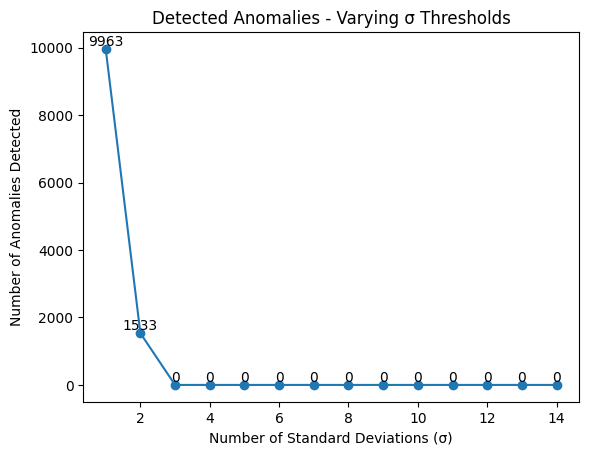

In [20]:
x_values = list(range(1, 15))
plt.plot(x_values, num_anomalies_std, marker='o')

for x, y in zip(x_values, num_anomalies_std):
    plt.text(x, y, str(y), ha='center', va='bottom', fontsize=10)

plt.xlabel('Number of Standard Deviations (σ)')
plt.ylabel('Number of Anomalies Detected')
plt.title('Detected Anomalies - Varying σ Thresholds')

plt.show()

In [21]:
pos_scores.std()

tensor(0.2305)

In [22]:
# at 2 std
threshold = pos_scores.mean() - pos_scores.std()
anomalies = pos_scores < threshold

anomalous_idx = anomalies.nonzero(as_tuple=True)[0]
anomalous_pairs = pos_edge_index[:, anomalous_idx]

print(f"Anomalous Real Edges (< {threshold:.4f}):\n")
for u, v in anomalous_pairs.t():
    vendor_id = vendor_enc.inverse_transform([u.item()])[0]
    contract_id = contract_enc.inverse_transform([v.item()])[0]
    score = edge_recon_scores(z_dict, torch.tensor([[u], [v]]), 'vendor', 'contract').item()
    print(f"Vendor {vendor_id} -> Contract {contract_id} | Rec. Prob.: {score:.4f}")

Anomalous Real Edges (< 0.3586):

Vendor U4K9M66MUHR9 -> Contract IND0407CT66810 | Rec. Prob.: 0.1291
Vendor JSAELFPYPZV1 -> Contract 6923G220C000007 | Rec. Prob.: 0.1193
Vendor M21NBLGE6EM5 -> Contract W912DS22C0002 | Rec. Prob.: 0.2531
Vendor J3EHPWF5BSD3 -> Contract 47PE0221C0004 | Rec. Prob.: 0.2987
Vendor HKRVPDJJ42G3 -> Contract W912PL23C0009 | Rec. Prob.: 0.2695
Vendor PWMFYG34A469 -> Contract W9124N10C0024 | Rec. Prob.: 0.2294
Vendor TX8AT2QM27K5 -> Contract FA452814C3001 | Rec. Prob.: 0.2741
Vendor JMXUUGWTKLD8 -> Contract AG32SCC120021 | Rec. Prob.: 0.3102
Vendor WNG6CEHSKTN9 -> Contract AG92X95082X940181 | Rec. Prob.: 0.3426
Vendor RHDSJJX1JL85 -> Contract GS03P16QKC7053 | Rec. Prob.: 0.0964
Vendor HE2QULKCL2T5 -> Contract GS05P16SVC7026 | Rec. Prob.: 0.2642
Vendor VL5HTBP1FZ79 -> Contract 47PG0422C0006 | Rec. Prob.: 0.1369
Vendor ZB4FFPMFKB64 -> Contract INP11PC60632 | Rec. Prob.: 0.1321
Vendor D5PNNVYQKC94 -> Contract 12FPC322C0002 | Rec. Prob.: 0.2613
Vendor ZXX9BLSL71Y8 

Vendor D5UMMENSEAR5 -> Contract 47PG0018C0001 | Rec. Prob.: 0.3074
Vendor D1LRKHNWT971 -> Contract 47PK1720C0023 | Rec. Prob.: 0.2769
Vendor YYWYLQCPCBV1 -> Contract W912DS07C0010 | Rec. Prob.: 0.2597
Vendor GDH5ESJBVDM5 -> Contract W9128F17C0013 | Rec. Prob.: 0.3169
Vendor J2W3W7JA6KP8 -> Contract GS11P05YTC0267 | Rec. Prob.: 0.3187
Vendor F3PQM5C4ATN8 -> Contract W912QR19C0024 | Rec. Prob.: 0.3063
Vendor SUWDTFGEHYV1 -> Contract GS05P06FBC0005 | Rec. Prob.: 0.0086
Vendor W27HWYZ1JFL1 -> Contract VA241C1996 | Rec. Prob.: 0.2474
Vendor FAYENXTN1JL4 -> Contract W91QV118C0126 | Rec. Prob.: 0.2908
Vendor REMFJMJ44EB6 -> Contract W15QKN17C1060 | Rec. Prob.: 0.3111
Vendor ZV1UKKUEEE52 -> Contract W9124207C0003 | Rec. Prob.: 0.1128
Vendor KC3NY1XDFUK9 -> Contract GY000200210DGS06P03GYD0004 | Rec. Prob.: 0.0415
Vendor MEKRC9F8BZY7 -> Contract VA256C0462 | Rec. Prob.: 0.3053
Vendor Y61CZ3NY44P7 -> Contract W912LA24C0002 | Rec. Prob.: 0.1521
Vendor MVREPKQXF5C3 -> Contract N4008017C4468 | Rec. 

Vendor CBHGJF4MMQ27 -> Contract VA52812C0083 | Rec. Prob.: 0.2911
Vendor MJ53XBDHP1B9 -> Contract N4008523C0048 | Rec. Prob.: 0.2870
Vendor RK32PDMPRWR7 -> Contract GS09P02KYC0029 | Rec. Prob.: 0.2357
Vendor FX31HE15YGU7 -> Contract 36C24124C0050 | Rec. Prob.: 0.3365
Vendor YATVG8LXF653 -> Contract DTFAEA09C00228 | Rec. Prob.: 0.2934
Vendor D1LRKHNWT971 -> Contract 47PK1020C0009 | Rec. Prob.: 0.3046
Vendor LEJAE6AKLFN8 -> Contract INICMK60070001 | Rec. Prob.: 0.2415
Vendor D4GBDJWGWJT8 -> Contract AG2415C150006 | Rec. Prob.: 0.3212
Vendor GAQBS71M9A85 -> Contract W911SA18C2026 | Rec. Prob.: 0.1671
Vendor SUWDTFGEHYV1 -> Contract DTFASW05C00002 | Rec. Prob.: 0.2333
Vendor HN5KSCMQHW13 -> Contract VA24412C0493 | Rec. Prob.: 0.3416
Vendor ZZVELNLCF7J3 -> Contract W9124M10C0009 | Rec. Prob.: 0.1455
Vendor XS27YPMDNVX8 -> Contract GS01P16NFC7023 | Rec. Prob.: 0.3369
Vendor RQFQBS2WSVW5 -> Contract VA25017C0133 | Rec. Prob.: 0.2245
Vendor QENKD6KUMED9 -> Contract HHSI102200700002C | Rec. Pro

Vendor V8LTMZ9HLAB9 -> Contract GS11P12YED0121 | Rec. Prob.: 0.3321
Vendor FA6NXN78D5R1 -> Contract VA257C0267 | Rec. Prob.: 0.3205
Vendor KZMRSJJJN1L6 -> Contract GS10P05XJC0043 | Rec. Prob.: 0.2089
Vendor KMSLVW1MZWU9 -> Contract FA488723C0015 | Rec. Prob.: 0.3443
Vendor HSEAK3YNT7H6 -> Contract GS08P04JCC0006 | Rec. Prob.: 0.2910
Vendor JWA7LVNPBSM5 -> Contract FA500011C0010 | Rec. Prob.: 0.2485
Vendor DLGLNC6MLBF7 -> Contract GS01P12NFC0020 | Rec. Prob.: 0.3299
Vendor F2E6AEZ4YEJ9 -> Contract INR08CC101709 | Rec. Prob.: 0.2222
Vendor CLJRF3T83FC9 -> Contract 6973GH19C00006 | Rec. Prob.: 0.1230
Vendor DT48EVBMED26 -> Contract AG56A1C090009 | Rec. Prob.: 0.1051
Vendor ZE2HCHPFBH93 -> Contract VA24517C0193 | Rec. Prob.: 0.3584
Vendor GW6LKDLCQBB8 -> Contract 140A1120C0001 | Rec. Prob.: 0.3053
Vendor HE2QULKCL2T5 -> Contract GS05P14SVC0084 | Rec. Prob.: 0.2660
Vendor U51KDXRRKEC1 -> Contract W9124A16C0008 | Rec. Prob.: 0.3215
Vendor LRE2MMECB9P7 -> Contract W9126G18C0135 | Rec. Prob.: 

Vendor SUWDTFGEHYV1 -> Contract DTFAEN15C00137 | Rec. Prob.: 0.2169
Vendor LKUGGSQH6PK9 -> Contract W912DY14C0037 | Rec. Prob.: 0.3472
Vendor KGX7UGQ3Y7H4 -> Contract DTFANE10C00129 | Rec. Prob.: 0.3235
Vendor HW2AAP4E7K52 -> Contract VA69DC0338 | Rec. Prob.: 0.3130
Vendor CMDKKY4211N7 -> Contract FA486110CA034 | Rec. Prob.: 0.3386
Vendor C87FYW7L8394 -> Contract GS04P13EXC0017 | Rec. Prob.: 0.3422
Vendor MXR3WNLDEDS6 -> Contract W912L309C0022 | Rec. Prob.: 0.2429
Vendor J7TKN4NXU166 -> Contract GS11P05YEC0263 | Rec. Prob.: 0.1249
Vendor XUJ6UAM48AV6 -> Contract VA69D14C0444 | Rec. Prob.: 0.1087
Vendor GPARR2SNK2K1 -> Contract W912WJ14C0031 | Rec. Prob.: 0.2371
Vendor K3Y7NLGJLN29 -> Contract W912HN08C0001 | Rec. Prob.: 0.2927
Vendor NH7JETMN3L59 -> Contract V687C451 | Rec. Prob.: 0.0809
Vendor N7VNJF16VCD3 -> Contract W912QR07C0052 | Rec. Prob.: 0.0939
Vendor CJKKN1NW6G28 -> Contract FA452819CA037 | Rec. Prob.: 0.2972
Vendor DS29YK4JMWP5 -> Contract GS04P15BVC0012 | Rec. Prob.: 0.3452

Vendor GCAJHD2D7518 -> Contract 140F0222C0009 | Rec. Prob.: 0.3242
Vendor RAXABZ5HZHV9 -> Contract 36C24822C0106 | Rec. Prob.: 0.0789
Vendor LALFKXYL3GL3 -> Contract GS03P07CDC0096 | Rec. Prob.: 0.3195
Vendor F3VQKKS8JD45 -> Contract W50S9825C0003 | Rec. Prob.: 0.1206
Vendor J9HVTKUKY1M5 -> Contract AE129820000345 | Rec. Prob.: 0.1274
Vendor PTSCYLWKCFK3 -> Contract 36C25223C0083 | Rec. Prob.: 0.3187
Vendor PABPQLCNDUM6 -> Contract 00623200305DV623C686 | Rec. Prob.: 0.0179
Vendor S3DGL38K5QY7 -> Contract DOCAB133F05CN1392 | Rec. Prob.: 0.1918
Vendor LAUGY4C2LTN1 -> Contract VA243C0238 | Rec. Prob.: 0.3351
Vendor XDFGDKSKJWF2 -> Contract W912HP15C0012 | Rec. Prob.: 0.3156
Vendor HG17C8B1NPB3 -> Contract W912DW13C0035 | Rec. Prob.: 0.1961
Vendor F3PQM5C4ATN8 -> Contract W912QR18C0008 | Rec. Prob.: 0.3091
Vendor P465J6U9CN99 -> Contract 47PG0721C0004 | Rec. Prob.: 0.2359
Vendor JYDKPL99QCC3 -> Contract VA263C1346 | Rec. Prob.: 0.3312
Vendor CMQGLNME9S36 -> Contract HQ009504C0002 | Rec. Pr

Vendor M9J7HQ6HJCM6 -> Contract 75H70119C00018 | Rec. Prob.: 0.3383
Vendor DLFCLTSCE9Y3 -> Contract FA485523C0025 | Rec. Prob.: 0.3566
Vendor HVEAJN7CKVG5 -> Contract 140L1720C0011 | Rec. Prob.: 0.3136
Vendor FYF1DNQHJV64 -> Contract GS02P10PWC0003 | Rec. Prob.: 0.2704
Vendor WVB6DLKZN3Q7 -> Contract 140P6020C0002 | Rec. Prob.: 0.2780
Vendor LEB7QPHJBBM5 -> Contract FA480018C0017 | Rec. Prob.: 0.0569
Vendor LPXYYU21LJS3 -> Contract W911S717C0202 | Rec. Prob.: 0.1811
Vendor CBHGJF4MMQ27 -> Contract VA52813C0113 | Rec. Prob.: 0.2916
Vendor ZJUMZMEKG2B6 -> Contract INP14PC00519 | Rec. Prob.: 0.1857
Vendor K1D4QJ5MBQR8 -> Contract VA69DC00148 | Rec. Prob.: 0.1173
Vendor F3XNVDG59VH7 -> Contract W912EK13C0050 | Rec. Prob.: 0.3016
Vendor CHHHTAY4LJH4 -> Contract W912PL10C0037 | Rec. Prob.: 0.3068
Vendor QHNRSW4GKEJ4 -> Contract DJB40105014 | Rec. Prob.: 0.2185
Vendor Q8H2NYQ1UGL9 -> Contract W912ER15C0010 | Rec. Prob.: 0.2486
Vendor TX3FJCG7BLF4 -> Contract W912DQ24C4022 | Rec. Prob.: 0.3586

Vendor SVQFXR2M5HD5 -> Contract W912ER19C0018 | Rec. Prob.: 0.2704
Vendor VE4AVDFNU343 -> Contract V255C589A50296 | Rec. Prob.: 0.1086
Vendor HNH8Z9K25289 -> Contract W911S707C0022 | Rec. Prob.: 0.2065
Vendor D4D1LCJPNZJ9 -> Contract 47PD1022C0010 | Rec. Prob.: 0.3149
Vendor KJAFCNCLLLT7 -> Contract VA595C0004 | Rec. Prob.: 0.3163
Vendor NA8DCMBLZAN1 -> Contract W912L516C0003 | Rec. Prob.: 0.3251
Vendor NKJ8LNAU4LH7 -> Contract INL13PC00005 | Rec. Prob.: 0.2404
Vendor D4D1LCJPNZJ9 -> Contract 47PD0622C0006 | Rec. Prob.: 0.3373
Vendor WDBEEY2VTJM9 -> Contract INF301814C073 | Rec. Prob.: 0.3454
Vendor EC3MR8JGLMN3 -> Contract ZG000200309DGS11P03ZGC0324 | Rec. Prob.: 0.3086
Vendor LRBEJLLLBUT1 -> Contract N6945017C6810 | Rec. Prob.: 0.2053
Vendor JVC8LSNKKTA3 -> Contract FA667518C0004 | Rec. Prob.: 0.1457
Vendor SENDML88AEK1 -> Contract V554C840 | Rec. Prob.: 0.3072
Vendor PCQHTLNLDUE6 -> Contract GS03P10CDC0040 | Rec. Prob.: 0.2252
Vendor DYKNLAFCBB33 -> Contract GS01P04BWC0125GSP0108NF0

Vendor WXXHBM7QT5L9 -> Contract W50S7U23C0003 | Rec. Prob.: 0.2237
Vendor F3K2LWVKFLX9 -> Contract W912DR23C0038 | Rec. Prob.: 0.3333
Vendor C9ASKCLEB279 -> Contract W912L506C0001 | Rec. Prob.: 0.1097
Vendor K7ZKPWE8UJU8 -> Contract GS03P09QKC0024 | Rec. Prob.: 0.3059
Vendor DQMVGPBT5PF5 -> Contract 12505B20C0003 | Rec. Prob.: 0.3129
Vendor J5FXQUCBKTH6 -> Contract GS03P16QNC7011 | Rec. Prob.: 0.3575
Vendor JLNDDS9KKWG3 -> Contract VA250C0212 | Rec. Prob.: 0.2059
Vendor NLLKV94M2BP3 -> Contract VA261C0428 | Rec. Prob.: 0.0342
Vendor MWBMMPQPYEV6 -> Contract W912PL24C0013 | Rec. Prob.: 0.2205
Vendor CZKDL1LF4BK9 -> Contract FA663322C0002 | Rec. Prob.: 0.1429
Vendor FJTKE7DAM3E9 -> Contract INLNDC050096 | Rec. Prob.: 0.2798
Vendor FLJBXP8TEX77 -> Contract VA528C0588 | Rec. Prob.: 0.2455
Vendor UAL5K5EL7YW7 -> Contract 36C78623C0009 | Rec. Prob.: 0.0301
Vendor M6G3M7N4XPS5 -> Contract W9128A09C0008 | Rec. Prob.: 0.2806
Vendor LTXMN3JJ4SC9 -> Contract W912PQ04C0012 | Rec. Prob.: 0.1974
Ven

Vendor WR5XNH8U4KM6 -> Contract 47PF0018C0054 | Rec. Prob.: 0.2129
Vendor DR5ZVGVALLL3 -> Contract W912WJ19C0011 | Rec. Prob.: 0.1156
Vendor FC5EMM6NFN85 -> Contract W9124719C0120 | Rec. Prob.: 0.3126
Vendor MEX9FCDC8H17 -> Contract W50S8F22C0001 | Rec. Prob.: 0.2602
Vendor FYF1DNQHJV64 -> Contract GS02P06PWC0027 | Rec. Prob.: 0.2663
Vendor D4D1LCJPNZJ9 -> Contract 47PE0222C0019 | Rec. Prob.: 0.3124
Vendor ZMNPZJK8YVN3 -> Contract 47PM1018C0051 | Rec. Prob.: 0.1624
Vendor UJJGGR1LD5K5 -> Contract N6247310C1636 | Rec. Prob.: 0.2978
Vendor N6F2MJSH4WM8 -> Contract NNA17BF84C | Rec. Prob.: 0.1514
Vendor H58GSJA68TM8 -> Contract W912L811C0002 | Rec. Prob.: 0.0942
Vendor CLJME3ENNXM6 -> Contract VA244C0355 | Rec. Prob.: 0.2707
Vendor XHJUKTAPU9F9 -> Contract 36C26123C0057 | Rec. Prob.: 0.2681
Vendor ZMNPZJK8YVN3 -> Contract 47PM1018C0025 | Rec. Prob.: 0.1623
Vendor YDELMED4JJ57 -> Contract W912PL22C0011 | Rec. Prob.: 0.3080
Vendor D1MKMDM65NK3 -> Contract GS08P17VJC0002 | Rec. Prob.: 0.2255

Vendor QX91C7GZDJS5 -> Contract FA930122C0005 | Rec. Prob.: 0.2273
Vendor FC5EMM6NFN85 -> Contract W9124720C0059 | Rec. Prob.: 0.2870
Vendor DTP4G6KAPP44 -> Contract VA24612C0035 | Rec. Prob.: 0.2932
Vendor UKJALGAAJB32 -> Contract 6973GH19C00073 | Rec. Prob.: 0.2118
Vendor XCHST6L53NH6 -> Contract 36C24419C0150 | Rec. Prob.: 0.3345
Vendor PV3GPHFD4217 -> Contract FA810118C0024 | Rec. Prob.: 0.3112
Vendor LKDMQPRQ72J5 -> Contract HSCG5011CPJT147 | Rec. Prob.: 0.3099
Vendor DYXTCAAZ8NY5 -> Contract W50S6Q23C0002 | Rec. Prob.: 0.1639
Vendor SCUWLHDYLMD8 -> Contract VA241C2441 | Rec. Prob.: 0.2597
Vendor UNLNRJPFNCL9 -> Contract W912ER17C0011 | Rec. Prob.: 0.1386
Vendor FYF1DNQHJV64 -> Contract GS02P05PWM0005 | Rec. Prob.: 0.2650
Vendor KDBTFL23HCW7 -> Contract VA24413C0050L | Rec. Prob.: 0.3382
Vendor ELJDZX7W6EY5 -> Contract VA256C0057 | Rec. Prob.: 0.2944
Vendor VMLJB3E2LLT6 -> Contract GS04P06EXC0025 | Rec. Prob.: 0.0397
Vendor SK6JAN13L911 -> Contract DJBCOB042 | Rec. Prob.: 0.3210
V

Vendor NJN5ME7S74K5 -> Contract TMHQ17C0035 | Rec. Prob.: 0.3269
Vendor M477SHHMMCZ5 -> Contract 36C25919C0104 | Rec. Prob.: 0.1651
Vendor SXAMQV94VND6 -> Contract HSFE1007C00064 | Rec. Prob.: 0.3231
Vendor L8K6PF7K3TH3 -> Contract DTFAAC16C00039 | Rec. Prob.: 0.1686
Vendor H484A1XG9VG5 -> Contract DACA2103C0040 | Rec. Prob.: 0.2215
Vendor K9REEC338KM7 -> Contract 6973GH20C00092 | Rec. Prob.: 0.2020
Vendor D4D1LCJPNZJ9 -> Contract 47PD1018C0016 | Rec. Prob.: 0.3138
Vendor ZJE3GTWE6D36 -> Contract W911SA11C0013 | Rec. Prob.: 0.3058
Vendor E29GMBJJ5R54 -> Contract 692M1521C00005 | Rec. Prob.: 0.1685
Vendor EFDCMCN2SVU6 -> Contract N6246705C9382 | Rec. Prob.: 0.3234
Vendor D4D1LCJPNZJ9 -> Contract 47PD1024C0008 | Rec. Prob.: 0.3416
Vendor XE3ZTN6KNPL1 -> Contract GS05P07SVC0025 | Rec. Prob.: 0.3484
Vendor DQ3ZZVMD3WD5 -> Contract INF10PC75091 | Rec. Prob.: 0.3321
Vendor DP31KANLHAT1 -> Contract 12805B19C0007 | Rec. Prob.: 0.2833
Vendor GMERB1YC5DL6 -> Contract W9124719C0106 | Rec. Prob.: 

Vendor NJN5ME7S74K5 -> Contract DOCSB134110CN0105 | Rec. Prob.: 0.2603
Vendor EQ63N4N7KLH7 -> Contract W911SA15C0004 | Rec. Prob.: 0.1684
Vendor EEPCF2DJKJM4 -> Contract W9127824C0005 | Rec. Prob.: 0.1522
Vendor QY9GYK6EYGN9 -> Contract W9127S05C6004 | Rec. Prob.: 0.2292
Vendor EVN8LLJPB3Y6 -> Contract W912PQ09C0011 | Rec. Prob.: 0.2931
Vendor UL7SN5LNUE29 -> Contract VA263RA0951 | Rec. Prob.: 0.2703
Vendor NM81ELYQBUA9 -> Contract 47PM0518C0005 | Rec. Prob.: 0.1633
Vendor J5FXQUCBKTH6 -> Contract HSBP1015C00071 | Rec. Prob.: 0.2385
Vendor ZE2HCHPFBH93 -> Contract N4008311C0010 | Rec. Prob.: 0.3507
Vendor N7N2X87NKC16 -> Contract N6247203C5717 | Rec. Prob.: 0.3162
Vendor PANFMJE2DYH2 -> Contract HM157505C0005 | Rec. Prob.: 0.2072
Vendor KVLPKWFDFRX3 -> Contract FA813721C0018 | Rec. Prob.: 0.2965
Vendor CY9LGPKEVTG7 -> Contract GS09P10WBC0046 | Rec. Prob.: 0.2676
Vendor W8YEBPE3TAJ1 -> Contract W912QR06C0050 | Rec. Prob.: 0.2526
Vendor XA4GB3AW3P25 -> Contract DACA6303C0005 | Rec. Prob.

Vendor XB5BEY6M29L9 -> Contract W912R118C0008 | Rec. Prob.: 0.1527
Vendor R6J4A33KEVN8 -> Contract FA330007C0020 | Rec. Prob.: 0.3499
Vendor M9J4QULBQKG6 -> Contract DTFAWP10C00099 | Rec. Prob.: 0.0704
Vendor LBN3YQSYM4P9 -> Contract INPC8000040901 | Rec. Prob.: 0.2972
Vendor DJD8BT884Q55 -> Contract DJF151200P0005803 | Rec. Prob.: 0.2350
Vendor LTPUJJSU6WN9 -> Contract AG82A7C160039 | Rec. Prob.: 0.3456
Vendor L13GF8SHQUY9 -> Contract W912BU09C0051 | Rec. Prob.: 0.1678
Vendor FYF1DNQHJV64 -> Contract V528C55100 | Rec. Prob.: 0.2869
Vendor G1NKCBXYFLH3 -> Contract W912QR17C0048 | Rec. Prob.: 0.1906
Vendor JBCEWWWHM5K1 -> Contract 00623200309DV623C701 | Rec. Prob.: 0.0650
Vendor J3BFVGAFNCL9 -> Contract VA260RA0717 | Rec. Prob.: 0.2726
Vendor PH56PA8SL233 -> Contract 89503219CWA000019 | Rec. Prob.: 0.1747
Vendor TSQJL4QKTFS7 -> Contract W9126G17C0132 | Rec. Prob.: 0.3166
Vendor ZMRUA41BEH73 -> Contract N4008515C5015 | Rec. Prob.: 0.3223
Vendor TY99NKDZ8ZJ3 -> Contract FA281617C0029 | Re

Vendor LTTZP7SLLHF1 -> Contract FA301021C0009 | Rec. Prob.: 0.2234
Vendor HYR2MFK5J5N5 -> Contract V693C490 | Rec. Prob.: 0.1048
Vendor FQY3KH85GQ47 -> Contract DEAX6508WG80241 | Rec. Prob.: 0.2370
Vendor XD2DDMMB6ZA6 -> Contract W912ER19C0002 | Rec. Prob.: 0.2749
Vendor X8A3F6NQNXK5 -> Contract FA670306C0005 | Rec. Prob.: 0.3052
Vendor NVY5YJVCRJQ4 -> Contract GS05P09FBC0015 | Rec. Prob.: 0.2693
Vendor W27HWYZ1JFL1 -> Contract VA241C2041 | Rec. Prob.: 0.2593
Vendor HXEMD2MKRMQ6 -> Contract VA263C1271 | Rec. Prob.: 0.3307
Vendor JV1NFDGGB4S4 -> Contract W912QR07C0057 | Rec. Prob.: 0.2664
Vendor MXR3WNLDEDS6 -> Contract W912L312C5006 | Rec. Prob.: 0.2719
Vendor PFKFJR4UWJE8 -> Contract VA250C0663 | Rec. Prob.: 0.1216
Vendor CA9KMFKBBM13 -> Contract W9127S08C6001 | Rec. Prob.: 0.1031
Vendor GM8SNYBK94D7 -> Contract W912DQ23C4035 | Rec. Prob.: 0.3531
Vendor M34GPJWKR1K4 -> Contract FA813721C0025 | Rec. Prob.: 0.2031
Vendor UTLJZN3NFEM3 -> Contract V69DC6248A | Rec. Prob.: 0.0719
Vendor JZ

Vendor HCJFAHEJWLD5 -> Contract W50S8T21C0005 | Rec. Prob.: 0.1045
Vendor G1N8QZDNYBU9 -> Contract V249C0061 | Rec. Prob.: 0.1874
Vendor HXEMD2MKRMQ6 -> Contract VA263C1060 | Rec. Prob.: 0.3128
Vendor YYWYLQCPCBV1 -> Contract W912DS12C0020 | Rec. Prob.: 0.2606
Vendor HUPADC35TJA4 -> Contract 70Z08218CPMV16800 | Rec. Prob.: 0.1949
Vendor ZMNPZJK8YVN3 -> Contract 47PM1018C0020 | Rec. Prob.: 0.1624
Vendor MMGJB35MY469 -> Contract DACA5103C0028 | Rec. Prob.: 0.2413
Vendor C6VMQ977W9X7 -> Contract NNC05CB16C | Rec. Prob.: 0.1729
Vendor DAEVLK3A7XF5 -> Contract GS09P08WDC0038 | Rec. Prob.: 0.2847
Vendor RQEAADJHKE44 -> Contract VA692C0016 | Rec. Prob.: 0.1334
Vendor DP31KANLHAT1 -> Contract GS00P16LYC7005 | Rec. Prob.: 0.1925
Vendor MRT5NMVQQDL8 -> Contract W9115107C0086 | Rec. Prob.: 0.3447
Vendor JHKSHJY2NNJ8 -> Contract V51904176 | Rec. Prob.: 0.2352
Vendor CEHNA6XZU795 -> Contract NGA13267HB12 | Rec. Prob.: 0.2137
Vendor HAK5J5BL9AD9 -> Contract W912WJ11C0002 | Rec. Prob.: 0.3232
Vendor 

Vendor M3L4YFHK6J36 -> Contract HSCGG117NPRV175 | Rec. Prob.: 0.3402
Vendor TQ2SAF4E9476 -> Contract VA244C0329 | Rec. Prob.: 0.0910
Vendor GT49JMDH8NA6 -> Contract V247C0405 | Rec. Prob.: 0.1412
Vendor GRV5FH5RPKL3 -> Contract VA244P1360 | Rec. Prob.: 0.0877
Vendor DFUNRFMG4915 -> Contract W912JM17C0014 | Rec. Prob.: 0.1244
Vendor LVCTL5FMXDX3 -> Contract W912DR10C0073 | Rec. Prob.: 0.3316
Vendor W9YGCN2XMBK8 -> Contract W912PQ13C0013 | Rec. Prob.: 0.0927
Vendor M8DAKWPYMFA3 -> Contract 140F0122C0114 | Rec. Prob.: 0.2447
Vendor LR81Y47Y83N5 -> Contract FA302012C0013 | Rec. Prob.: 0.2316
Vendor RYW4JA4H5MQ7 -> Contract VA244C0746 | Rec. Prob.: 0.1813
Vendor U9JUPGAKHRQ5 -> Contract VA246C0578 | Rec. Prob.: 0.0839
Vendor HLCXKJNH85L9 -> Contract 140R2018C0012 | Rec. Prob.: 0.2520
Vendor PY8EUERLAA35 -> Contract W912DR20C0069 | Rec. Prob.: 0.3440
Vendor CA9KMFKBBM13 -> Contract GS05P08SVC0020 | Rec. Prob.: 0.1616
Vendor ST3CKN516Y97 -> Contract 36C24223C0133 | Rec. Prob.: 0.2986
Vendor Z

Vendor D8A6W681LYK1 -> Contract HHSI102200700014C | Rec. Prob.: 0.2594
Vendor PXK5P2VU75E1 -> Contract AG32SDC130057 | Rec. Prob.: 0.2400
Vendor VRZZLWCJQU93 -> Contract VA245C0544 | Rec. Prob.: 0.2606
Vendor RX7JQ531A3Q8 -> Contract W912HP20C3002 | Rec. Prob.: 0.2972
Vendor GY8EADN4HMH3 -> Contract RA000200301DGS04P03EWC0146 | Rec. Prob.: 0.0437
Vendor FC5EMM6NFN85 -> Contract W911SF19C0032 | Rec. Prob.: 0.2496
Vendor HE7SLBYD2QR7 -> Contract V678C08318A | Rec. Prob.: 0.2043
Vendor XA7GMP6HF2L8 -> Contract GS03P10DXC0036 | Rec. Prob.: 0.2420
Vendor GWQ5K46L6AZ3 -> Contract W912HN24C3002 | Rec. Prob.: 0.2518
Vendor NG52QCDJKW96 -> Contract 140P2023C0124 | Rec. Prob.: 0.2082
Vendor NK3NA9L6P4N7 -> Contract 36C24218C0134 | Rec. Prob.: 0.2825
Vendor U51KDXRRKEC1 -> Contract W9124A20C0006 | Rec. Prob.: 0.3204
Vendor X8TRS2E57J16 -> Contract W911SG10C0005 | Rec. Prob.: 0.0859
Vendor SC89KKMN3F25 -> Contract VA263C0679 | Rec. Prob.: 0.2488
Vendor D89LEE6THDG1 -> Contract DTFASA17C00796 | Rec

Vendor N78KKEV1N7V7 -> Contract 36C24224C0034 | Rec. Prob.: 0.3263
Vendor JF45HLE1BFF6 -> Contract INA16PC00050 | Rec. Prob.: 0.3181
Vendor ST9XJA2ZKF71 -> Contract FA860105C0034 | Rec. Prob.: 0.1700
Vendor WXE7G127JJ63 -> Contract W912BV14C0002 | Rec. Prob.: 0.3166
Vendor FFMXL1D1LLR4 -> Contract FA441814C0012 | Rec. Prob.: 0.3086
Vendor KK7LBUWEZBJ1 -> Contract VA250C0409 | Rec. Prob.: 0.1922
Vendor S3BNL6LJVNW3 -> Contract 47PJ0019C0094 | Rec. Prob.: 0.2688
Vendor Q2QXZ2QZZMG9 -> Contract W912QR10C0057 | Rec. Prob.: 0.1101
Vendor U51KDXRRKEC1 -> Contract W9124A16C0006 | Rec. Prob.: 0.3239
Vendor YWJ5YNB1M4W5 -> Contract INR06CC603100 | Rec. Prob.: 0.1968
Vendor NUSXWN6MXGL7 -> Contract DOCWC133W07CN0184 | Rec. Prob.: 0.3238
Vendor KK59P425Q2H3 -> Contract W912DQ24C4036 | Rec. Prob.: 0.2684
Vendor MA29MHGNJWF3 -> Contract GS05P13SCC0047 | Rec. Prob.: 0.3474
Vendor H4RCJBNCETE1 -> Contract GS03P11CDC0003 | Rec. Prob.: 0.3154
Vendor X1EYDZ8H1FV5 -> Contract 47PG0217C0003 | Rec. Prob.: 

Vendor CQ8UX1QCW4M5 -> Contract VA250C0177 | Rec. Prob.: 0.1777
Vendor DCHMZAV542G6 -> Contract FA667522C0002 | Rec. Prob.: 0.3411
Vendor ENJ3S1LZF839 -> Contract VA24615C0058 | Rec. Prob.: 0.2711
Vendor QUACRBQMCDN5 -> Contract W911RQ14C0003 | Rec. Prob.: 0.2455
Vendor WQNLHU9R6HU1 -> Contract GY000200302DGS06P03GYC0001 | Rec. Prob.: 0.0577
Vendor MXNKE5JQ1828 -> Contract W91QF407C0017 | Rec. Prob.: 0.2683
Vendor L1DJNDAV1L65 -> Contract 36C26119C0117 | Rec. Prob.: 0.1195
Vendor UH16D6FG29P3 -> Contract GS03P08CDC0047 | Rec. Prob.: 0.0840
Vendor UFWKQY16YDY3 -> Contract INPC5580070003 | Rec. Prob.: 0.2477
Vendor PLAZNUWPAFK4 -> Contract VA250C0603 | Rec. Prob.: 0.1538
Vendor S24YFL9X18W8 -> Contract 47PH0523C0006 | Rec. Prob.: 0.2999
Vendor GCLFFSHVY9F3 -> Contract W9128F14C0009 | Rec. Prob.: 0.3301
Vendor HSWPUL9KE7Y3 -> Contract VA255C0590 | Rec. Prob.: 0.2795
Vendor JWDUW5BYQLM4 -> Contract 36C77624C0133 | Rec. Prob.: 0.0734
Vendor GGRKUPWBHHK5 -> Contract 140P4218C0031 | Rec. Prob

Vendor LQ7BY5LJSCR1 -> Contract VA24312C0251 | Rec. Prob.: 0.3104
Vendor WR5XNH8U4KM6 -> Contract 47PF0019C0103 | Rec. Prob.: 0.2002
Vendor N6CTZBFDV5J6 -> Contract 36C77622C0094 | Rec. Prob.: 0.3432
Vendor MDFNAY5HUNA6 -> Contract FA282313C4019 | Rec. Prob.: 0.0539
Vendor DQ9EC4N584S6 -> Contract W91ZRU19C5006 | Rec. Prob.: 0.3067
Vendor R1KEYDNLL929 -> Contract W912DS07C0007 | Rec. Prob.: 0.1634
Vendor JHJNMKEPMEN5 -> Contract GS10P02LTC0120 | Rec. Prob.: 0.2076
Vendor TS6LTP52UBM1 -> Contract 00255200309DV255C589A50243 | Rec. Prob.: 0.1205
Vendor GTJNB51TQLV6 -> Contract 36C25620C0090 | Rec. Prob.: 0.2960
Vendor CBHGJF4MMQ27 -> Contract 36C24224C0015 | Rec. Prob.: 0.2953
Vendor PABPQLCNDUM6 -> Contract HH000200308DGS07P03HHD0164 | Rec. Prob.: 0.0198
Vendor L4AAL5CJQFN7 -> Contract W50S8V22C0007 | Rec. Prob.: 0.1176
Vendor RGUXEPAQY1D9 -> Contract 75D30120C08065 | Rec. Prob.: 0.2736
Vendor XBGKEQ3Y7BN6 -> Contract VA52812C0173 | Rec. Prob.: 0.3265
Vendor GLVMLEWS5G95 -> Contract VA25

Vendor CJLPYEGMQXA7 -> Contract INP13PC00193 | Rec. Prob.: 0.2556
Vendor HSW5H3JLGDK8 -> Contract W912QR09C0026 | Rec. Prob.: 0.1821
Vendor JAQKBV1TCAK4 -> Contract 36C24624C0013 | Rec. Prob.: 0.1743
Vendor KZMRSJJJN1L6 -> Contract XJ000200306DGS10P03XJC0058 | Rec. Prob.: 0.2153
Vendor F6PDB4NCCXD3 -> Contract W912ER19C0008 | Rec. Prob.: 0.1169
Vendor EW9BHC7LUS33 -> Contract 00246200309DV246C00113 | Rec. Prob.: 0.1418
Vendor KLT3PHE44M39 -> Contract V247C0302 | Rec. Prob.: 0.1031
Vendor DMZ8ZKLXAN65 -> Contract W912DQ14C4019 | Rec. Prob.: 0.3289
Vendor GEBAR2WF37L6 -> Contract W9124722C0091 | Rec. Prob.: 0.3425
Vendor VAF2J9FP4812 -> Contract W912DS08C0020 | Rec. Prob.: 0.3296
Vendor Z4VAPEHWL9X9 -> Contract VA24813C0066 | Rec. Prob.: 0.3240
Vendor CY9LGPKEVTG7 -> Contract GS09P13WBC0013 | Rec. Prob.: 0.2758
Vendor EJL6SUNMX5E7 -> Contract AG0355C080029 | Rec. Prob.: 0.3364
Vendor FN1XY2A5J4H7 -> Contract GS11P07MAM0283 | Rec. Prob.: 0.1879
Vendor NW2RJN8TQQW1 -> Contract 00518200309D

Vendor UCZVULUNWQM1 -> Contract W912HY12C0020 | Rec. Prob.: 0.2967
Vendor JEHNESDYA9H1 -> Contract DAHA4103C0033 | Rec. Prob.: 0.1892
Vendor GP6GLEH5PR71 -> Contract VA250C0259 | Rec. Prob.: 0.2342
Vendor S5X1BMWK1P25 -> Contract 140P4519C0024 | Rec. Prob.: 0.2951
Vendor E7MKMAXSQF11 -> Contract DTFAGL09C00252 | Rec. Prob.: 0.2702
Vendor KKRFJ2317KG4 -> Contract VA69D16C0267 | Rec. Prob.: 0.2439
Vendor ELE6QLHLR1A6 -> Contract FA466105C0015 | Rec. Prob.: 0.3320
Vendor D4D1LCJPNZJ9 -> Contract 47PD0118C0001 | Rec. Prob.: 0.3141
Vendor DZA9PTMTNGJ8 -> Contract W9126G20C0055 | Rec. Prob.: 0.2008
Vendor UP32LBKQKUQ9 -> Contract GS01P10NFC0003 | Rec. Prob.: 0.2813
Vendor NAL4K5D7CST5 -> Contract VA24417C0298 | Rec. Prob.: 0.2533
Vendor H2M4VVBULAT6 -> Contract 140L0619C0029 | Rec. Prob.: 0.2416
Vendor DTKVELNRNBG7 -> Contract N4008517C4607 | Rec. Prob.: 0.3264
Vendor S931LTFN63M7 -> Contract N6247704C0524 | Rec. Prob.: 0.3170
Vendor PCP6KCT29KZ8 -> Contract VA25712C0051 | Rec. Prob.: 0.0841

Vendor NW2RJN8TQQW1 -> Contract VA256C0408 | Rec. Prob.: 0.0825
Vendor FHUPMQMATC15 -> Contract N6895003C0027 | Rec. Prob.: 0.2202
Vendor VNE5EB4V97J7 -> Contract FA813724C0010 | Rec. Prob.: 0.2943
Vendor EPX1V7WE8MB4 -> Contract AG32KWC140026 | Rec. Prob.: 0.1916
Vendor WX8TAZJLSFL8 -> Contract W9123818C0020 | Rec. Prob.: 0.1816
Vendor D3K5JUKAS3N7 -> Contract DTFACN11C00076 | Rec. Prob.: 0.1645
Vendor XS27YPMDNVX8 -> Contract INPC1700090602 | Rec. Prob.: 0.2134
Vendor HPCTKE4DCTY9 -> Contract GS03P06CDC0059 | Rec. Prob.: 0.3567
Vendor W27HWYZ1JFL1 -> Contract VA595C0006 | Rec. Prob.: 0.2642
Vendor EQ8VHZFSBHL7 -> Contract VA244C1096 | Rec. Prob.: 0.3455
Vendor Y7NGPEBNCM73 -> Contract DABK2103C0018 | Rec. Prob.: 0.2752
Vendor PU22G63NDZG8 -> Contract 47PM0121C0001 | Rec. Prob.: 0.1866
Vendor NE7LHV5QC1N7 -> Contract FA480107C0011 | Rec. Prob.: 0.1565
Vendor XB5BEY6M29L9 -> Contract 47PD0519C0006 | Rec. Prob.: 0.3561
Vendor S4YPCBRFMMT5 -> Contract W912PQ08C0031 | Rec. Prob.: 0.1189
V

Vendor H94XVDGNVNE6 -> Contract W912L113C0014 | Rec. Prob.: 0.2367
Vendor WTDVA1NN9JH8 -> Contract W912HN20C3007 | Rec. Prob.: 0.3453
Vendor D78ESM2SDJV6 -> Contract 36C77624C0154 | Rec. Prob.: 0.3203
Vendor D78ESM2SDJV6 -> Contract VA251C0848 | Rec. Prob.: 0.2936
Vendor LA7LXD4CPM55 -> Contract INR14PC00092 | Rec. Prob.: 0.2764
Vendor UH4JY3JCCY97 -> Contract 1305M322CNRMJ0056 | Rec. Prob.: 0.1680
Vendor H542NBJR8EM4 -> Contract GS11P12MAM0228 | Rec. Prob.: 0.2470
Vendor L76ZSHNB61Z3 -> Contract W912L820C0004 | Rec. Prob.: 0.1766
Vendor LH81Z1MB3VT3 -> Contract 00247200308DV247C01898A | Rec. Prob.: 0.3016
Vendor EWR6BEB5JDZ6 -> Contract W9127S07C6003 | Rec. Prob.: 0.1498
Vendor SAP4R6DVL5B3 -> Contract 47PM1018C0038 | Rec. Prob.: 0.3315
Vendor DRZYN7F3EN77 -> Contract W912QR17C0008 | Rec. Prob.: 0.3143
Vendor L13GF8SHQUY9 -> Contract W912QR22C0040 | Rec. Prob.: 0.1538
Vendor JPEAVKYG37S3 -> Contract DACA2195C0165 | Rec. Prob.: 0.0794
Vendor CL9QRKTXF8T3 -> Contract W9124B10C0011 | Rec

Vendor WQNLHU9R6HU1 -> Contract GS06P05TBC0019 | Rec. Prob.: 0.0475
Vendor REVCWBHHY735 -> Contract VA248C1402 | Rec. Prob.: 0.3177
Vendor QENKD6KUMED9 -> Contract V260C00020 | Rec. Prob.: 0.1670
Vendor FXJ8CJTNULQ3 -> Contract VA244P0476 | Rec. Prob.: 0.0677
Vendor FMK8PA8K3ZM5 -> Contract W912DS19C0033 | Rec. Prob.: 0.2402
Vendor T4VBNXVVE9T1 -> Contract W912KC12C0006 | Rec. Prob.: 0.2621
Vendor HDUJBBTU67F3 -> Contract 47PB0020C0002 | Rec. Prob.: 0.3495
Vendor ETSCRJG393L1 -> Contract 36C24823C0109 | Rec. Prob.: 0.2179
Vendor K2TCU3H9TC17 -> Contract 36C24620C0048 | Rec. Prob.: 0.3387
Vendor Z4VAPEHWL9X9 -> Contract VA248C1585 | Rec. Prob.: 0.3465
Vendor V111U8F9QFU3 -> Contract 140F0322C0007 | Rec. Prob.: 0.1972
Vendor ULNZDANYWP88 -> Contract 47PG0725C0001 | Rec. Prob.: 0.2400
Vendor CNB5RPRFARQ9 -> Contract INF40181RC015 | Rec. Prob.: 0.2227
Vendor WKLSQ2ZZ6H93 -> Contract 1232SD18C0091 | Rec. Prob.: 0.2477
Vendor JWKENJ45GK65 -> Contract W912HP20C1005 | Rec. Prob.: 0.3033
Vendor

Vendor DYKNLAFCBB33 -> Contract GS01P04BWC0125GSP0107NF0011 | Rec. Prob.: 0.3572
Vendor N578ZLNW7KY5 -> Contract W911S710C0053 | Rec. Prob.: 0.2530
Vendor UH16D6FG29P3 -> Contract 36C24518C0045 | Rec. Prob.: 0.3128
Vendor D8GGP2SJKJ85 -> Contract W9124721C0004 | Rec. Prob.: 0.3427
Vendor JQ1EULCXLK28 -> Contract GS06P12TEC0018 | Rec. Prob.: 0.3434
Vendor QD7DPKBQXKE3 -> Contract W912QR04C0007 | Rec. Prob.: 0.2560
Vendor ZMNPZJK8YVN3 -> Contract 47PM1018C0043 | Rec. Prob.: 0.1624
Vendor ED7XURXJM6D1 -> Contract W911SG22C0017 | Rec. Prob.: 0.2794
Vendor WYSRYW74KD91 -> Contract VA251C1006 | Rec. Prob.: 0.2217
Vendor UF7ACYDQFH83 -> Contract W9126G14C0135 | Rec. Prob.: 0.3059
Vendor D56MUMNUV8S5 -> Contract 15M30024CA3700022 | Rec. Prob.: 0.0477
Vendor WUZZKLRJL183 -> Contract VA259C0310 | Rec. Prob.: 0.2139
Vendor CKDLL7FWH1K3 -> Contract HDEC0311C0002 | Rec. Prob.: 0.2515
Vendor JKFRCGH32HT3 -> Contract INIDABQ1100029 | Rec. Prob.: 0.2119
Vendor UL7SN5LNUE29 -> Contract VA263RA0950 | Re

Vendor FN23WFREPGE3 -> Contract GS11P10YEC0164 | Rec. Prob.: 0.3502
Vendor PGNAGUB2A7L1 -> Contract GS04P16EXC7174 | Rec. Prob.: 0.2998
Vendor MXN8TV7ETNV6 -> Contract GS08P17JCC0007 | Rec. Prob.: 0.0924
Vendor EURUZM9DMQA9 -> Contract GS03P17QAC0016 | Rec. Prob.: 0.2862
Vendor JF45HLE1BFF6 -> Contract W912PP18C0002 | Rec. Prob.: 0.2877
Vendor JH18CJJMKMZ8 -> Contract WL000200203DGS09P03WLC0019 | Rec. Prob.: 0.0739
Vendor VLCCDCPWF9F2 -> Contract GS05P03GAC0101 | Rec. Prob.: 0.3293
Vendor NQPFTGCJHGG5 -> Contract DACA0103C0003 | Rec. Prob.: 0.1426
Vendor F1KJKEKBF791 -> Contract W9124219C5004 | Rec. Prob.: 0.1790
Vendor DJ3BBTYS5CM1 -> Contract FA301622C0070 | Rec. Prob.: 0.1626
Vendor DTP4G6KAPP44 -> Contract VA24516C0023 | Rec. Prob.: 0.2540
Vendor X1YLPZ5A1RM5 -> Contract 36C24424C0003 | Rec. Prob.: 0.0748
Vendor EZRCWXVBZME5 -> Contract VA69DRA1413 | Rec. Prob.: 0.3286
Vendor MMHMAS7DHKM1 -> Contract INP17PC00189 | Rec. Prob.: 0.1430
Vendor STJXNA5AA7F4 -> Contract INLNDC040003 | R

Vendor H94XVDGNVNE6 -> Contract W912L115C0033 | Rec. Prob.: 0.2367
Vendor LWJKTKBW36R5 -> Contract AG8399C160024 | Rec. Prob.: 0.2621
Vendor RLDUT4AS31N5 -> Contract DTFACT12C00002 | Rec. Prob.: 0.3165
Vendor J6TKK1KB36B7 -> Contract FA302004C0010 | Rec. Prob.: 0.2755
Vendor M6G3M7N4XPS5 -> Contract W911KB06C0016 | Rec. Prob.: 0.2652
Vendor LPUNTBN4CNK3 -> Contract 47PF0017C0033 | Rec. Prob.: 0.2215
Vendor R6CPWWDD4AM1 -> Contract GS11P04MKC0003 | Rec. Prob.: 0.3006
Vendor NG97DMANHX47 -> Contract VA255C0034 | Rec. Prob.: 0.3348
Vendor GHLZEAA8BLS9 -> Contract AG9A40C050019 | Rec. Prob.: 0.1255
Vendor DRC1NYK9H2J6 -> Contract VA251C1120 | Rec. Prob.: 0.3129
Vendor HERXJEEWZFL7 -> Contract W564KV17C0002 | Rec. Prob.: 0.3220
Vendor MZSZLC7TJPA5 -> Contract AE127590000320 | Rec. Prob.: 0.2855
Vendor J6LNN7C4WZ86 -> Contract VA24912C0268 | Rec. Prob.: 0.1255
Vendor PTSCYLWKCFK3 -> Contract VA69D12C0147 | Rec. Prob.: 0.3240
Vendor MMBHJL3CJ9S5 -> Contract W912DW19C0017 | Rec. Prob.: 0.1919


Vendor LXC6T8UQ56M9 -> Contract N4008008C0026 | Rec. Prob.: 0.0462
Vendor NE7LHV5QC1N7 -> Contract AG7512C130007 | Rec. Prob.: 0.3437
Vendor E2TXH1QK3H55 -> Contract FA286013C0002 | Rec. Prob.: 0.2025
Vendor LCJ3FY3T4J43 -> Contract W912SV19C0003 | Rec. Prob.: 0.3559
Vendor CQ8UX1QCW4M5 -> Contract VA251C0530 | Rec. Prob.: 0.1780
Vendor VUTGFJWNPLJ9 -> Contract W912JV04C0005 | Rec. Prob.: 0.1645
Vendor RADFYDPNJJA3 -> Contract W912L812C0013 | Rec. Prob.: 0.2095
Vendor HHWNBYZHKMC5 -> Contract W91QV118C0123 | Rec. Prob.: 0.2374
Vendor UGPNR19PJF31 -> Contract W912DY09C0003 | Rec. Prob.: 0.1820
Vendor CL9QRKTXF8T3 -> Contract INP12PC01887 | Rec. Prob.: 0.1383
Vendor PJUXUM1DNHN3 -> Contract INPC1574070056 | Rec. Prob.: 0.2060
Vendor HXMJA2V68HC3 -> Contract W912CG06C0004 | Rec. Prob.: 0.3548
Vendor EJL6SUNMX5E7 -> Contract 1282B123C0005 | Rec. Prob.: 0.3208
Vendor PQEGB3Q8MGG9 -> Contract W912C905C0008 | Rec. Prob.: 0.1910
Vendor ZUMBU6EJL5N5 -> Contract VA261C0086 | Rec. Prob.: 0.2095
V

Vendor KLRDMDZ93RG5 -> Contract FA667510C0026 | Rec. Prob.: 0.1780
Vendor ZMXKZMR17JL6 -> Contract 36C25623C0094 | Rec. Prob.: 0.2563
Vendor KZ5NLD4Q9JL4 -> Contract GS05P17SCC0003 | Rec. Prob.: 0.0519
Vendor D4D1LCJPNZJ9 -> Contract 47PD0618C0001 | Rec. Prob.: 0.3416
Vendor CYMKXKNMJ9M6 -> Contract AG5114C060003 | Rec. Prob.: 0.2071
Vendor GWNJALUM93K4 -> Contract 36C78619C0035 | Rec. Prob.: 0.3079
Vendor DCB5M5J72J35 -> Contract 47PG0722C0008 | Rec. Prob.: 0.2624
Vendor EULPCQH4J2X9 -> Contract 47PH0618C0008 | Rec. Prob.: 0.1988
Vendor KKHJFLYKM5M5 -> Contract VA257C0082 | Rec. Prob.: 0.2854
Vendor PJUXUM1DNHN3 -> Contract INPC1574040219 | Rec. Prob.: 0.2419
Vendor LB2NAQCMFHN5 -> Contract FA820107C0085 | Rec. Prob.: 0.2578
Vendor FLM4ZKCJM3Q4 -> Contract W9126G20C0032 | Rec. Prob.: 0.2239
Vendor KL49F2CMKK15 -> Contract W91QEY10C0006 | Rec. Prob.: 0.1660
Vendor QHU1JXKM7D51 -> Contract W9124312C0003 | Rec. Prob.: 0.2542
Vendor RVJMA4L7T745 -> Contract V512C60419 | Rec. Prob.: 0.1712

Vendor HE7KKMMCLDW1 -> Contract GY000200106DGS06P01GYC0005 | Rec. Prob.: 0.0824
Vendor FC5EMM6NFN85 -> Contract W9124719C0044 | Rec. Prob.: 0.2580
Vendor XZGCZ86MJSE7 -> Contract GS06P09TKC0028 | Rec. Prob.: 0.2913
Vendor SCUWLHDYLMD8 -> Contract VA241C2053 | Rec. Prob.: 0.2664
Vendor ESQ7WWJFXE63 -> Contract PW000200308DGS02P03PWC0082 | Rec. Prob.: 0.1399
Vendor GVPGHMVV3HV3 -> Contract 1305M324C0085 | Rec. Prob.: 0.2489
Vendor CHQ3Z614HPE1 -> Contract 15B41918CT3U40001 | Rec. Prob.: 0.0562
Vendor QH4WCEJ6LJZ8 -> Contract W912KZ16C0002 | Rec. Prob.: 0.2942
Vendor JMFJKHK9A778 -> Contract VA255C1535 | Rec. Prob.: 0.2710
Vendor MLMKS3MB4M77 -> Contract W912DR09C0080 | Rec. Prob.: 0.2547
Vendor R96MEFRL2CB3 -> Contract INP15PC00723 | Rec. Prob.: 0.3232
Vendor LEM5JPJFENJ3 -> Contract W9126G14C0077 | Rec. Prob.: 0.3311
Vendor F58RC49TLVM7 -> Contract ING06CRCN0005 | Rec. Prob.: 0.3431
Vendor HUD4MLEBNMM4 -> Contract W912QR08C0001 | Rec. Prob.: 0.0742
Vendor FU66JCQ3G8M6 -> Contract W911WN

Vendor LALFKXYL3GL3 -> Contract CD000200305DGS03P03CDC0035 | Rec. Prob.: 0.3318
Vendor MMGJB35MY469 -> Contract W912DS08C0012 | Rec. Prob.: 0.2431
Vendor E78TUSKZQZS3 -> Contract W9124M08C0012 | Rec. Prob.: 0.1724
Vendor W8CUD7D84QC3 -> Contract VA256C0369 | Rec. Prob.: 0.2273
Vendor JEJJZPGM2CJ7 -> Contract 36C25018C0215 | Rec. Prob.: 0.3312
Vendor DK6BPGB7G9R9 -> Contract VA256C1353 | Rec. Prob.: 0.2127
Vendor CX94XWQUWHJ9 -> Contract GS11P06MKC0041 | Rec. Prob.: 0.3367
Vendor JAKVNMEJLJK1 -> Contract W912QR17C0018 | Rec. Prob.: 0.1268
Vendor FA6NXN78D5R1 -> Contract VA25715C0176 | Rec. Prob.: 0.3133
Vendor D4D1LCJPNZJ9 -> Contract 47PD0521C0003 | Rec. Prob.: 0.3416
Vendor K3WGY3G3J9N9 -> Contract VA256C0634 | Rec. Prob.: 0.3471
Vendor LJGKMJ8GLUZ4 -> Contract GS05P15SIC7005 | Rec. Prob.: 0.3540
Vendor KC3NY1XDFUK9 -> Contract F2560003C0026 | Rec. Prob.: 0.0892
Vendor HPCTKE4DCTY9 -> Contract GS03P07CDC0032 | Rec. Prob.: 0.3293
Vendor PE3BPN7DKNF7 -> Contract GS10P12XJC0045 | Rec. Pr

Vendor DN6TFNNHU3B3 -> Contract HQ051618C0015 | Rec. Prob.: 0.0154
Vendor XE3ZTN6KNPL1 -> Contract GS05P08FBC0051 | Rec. Prob.: 0.3473
Vendor EJHTLA7NAFH4 -> Contract W912HN06C0018 | Rec. Prob.: 0.2417
Vendor FLM4ZKCJM3Q4 -> Contract 47PK0518C0007 | Rec. Prob.: 0.1235
Vendor CX5UJP8KKTR5 -> Contract INP16PC00461 | Rec. Prob.: 0.0753
Vendor CLJME3ENNXM6 -> Contract VA244C0508 | Rec. Prob.: 0.2922
Vendor C6XWDJGZJ9T1 -> Contract GS07P10UKC0041 | Rec. Prob.: 0.3140
Vendor J3YMW9339CN7 -> Contract DACA2193C0121 | Rec. Prob.: 0.1410
Vendor ZZVCEQM7B3F4 -> Contract 00247200309DV247C02008A | Rec. Prob.: 0.3555
Vendor WMD6CT8YXG49 -> Contract 47PF0018C0089 | Rec. Prob.: 0.2962
Vendor KR95DMJND5N5 -> Contract DOCWC133F13CN0136 | Rec. Prob.: 0.0812
Vendor WEFJZZZEV265 -> Contract 36C25223C0022 | Rec. Prob.: 0.1551
Vendor M4T6NF1QF2T3 -> Contract W912DS16C0027 | Rec. Prob.: 0.3061
Vendor NUBWPR118PN1 -> Contract JB000200210DGS08P03JBM0009 | Rec. Prob.: 0.0694
Vendor F3Y8HFLM98H4 -> Contract 36C25

Vendor JWEMUM8429K1 -> Contract W911SA19C2007 | Rec. Prob.: 0.2941
Vendor N5S2UQEWU8J9 -> Contract FA441609C0037 | Rec. Prob.: 0.0971
Vendor QFK5D4LAB798 -> Contract HSFE0616C0202 | Rec. Prob.: 0.0746
Vendor HMGZQFBHQ9C9 -> Contract V00241C00082 | Rec. Prob.: 0.2044
Vendor TFAJG6K8D696 -> Contract FA445222C0020 | Rec. Prob.: 0.1546
Vendor K8YNNAK6S5J3 -> Contract W911SG10C0032 | Rec. Prob.: 0.3210
Vendor VNE5EB4V97J7 -> Contract FA813721C0016 | Rec. Prob.: 0.2591
Vendor WK2GY3QSABJ8 -> Contract 140P1324C0003 | Rec. Prob.: 0.1735
Vendor HTXTNRJQKM71 -> Contract W9126G04C0040 | Rec. Prob.: 0.2880
Vendor U57RBYZ9J1A4 -> Contract GS10P15XAC7000 | Rec. Prob.: 0.0781
Vendor E2KRD5W4Y193 -> Contract W911YN05C0013 | Rec. Prob.: 0.1245
Vendor YCEABKDNAHA4 -> Contract DTCG4702C3EFK09 | Rec. Prob.: 0.1115
Vendor EDNNBUX9J6E1 -> Contract HHSD200200513486C | Rec. Prob.: 0.2898
Vendor MKWHDE3KA5M3 -> Contract GS11P12YED0122 | Rec. Prob.: 0.2998
Vendor D4D1LCJPNZJ9 -> Contract 47PD1018C0011 | Rec. Pr

Vendor WZRHJJXGXBM1 -> Contract 47PG0224C0003 | Rec. Prob.: 0.1910
Vendor VZCKAB8RKGQ7 -> Contract GS02P16PEC7011 | Rec. Prob.: 0.1244
Vendor GT6HFMJMSYC5 -> Contract W912PQ10C0017 | Rec. Prob.: 0.1233
Vendor CX94XWQUWHJ9 -> Contract GS11P05YTC0121 | Rec. Prob.: 0.3308
Vendor F1XFMBG2ZX73 -> Contract W912QR19C0045 | Rec. Prob.: 0.3170
Vendor MB1DL4QJJB86 -> Contract VA258C0312 | Rec. Prob.: 0.1797
Vendor UVR8K1KKR675 -> Contract VA25615C0027 | Rec. Prob.: 0.1013
Vendor XA4GB3AW3P25 -> Contract GS07P06UKC0025 | Rec. Prob.: 0.2225
Vendor UVR8K1KKR675 -> Contract DTFAAC08C00055 | Rec. Prob.: 0.2253
Vendor T72LMKXT4L69 -> Contract GS05P13SCC0067 | Rec. Prob.: 0.3570
Vendor HN5KSCMQHW13 -> Contract VA24512C0138 | Rec. Prob.: 0.3379
Vendor CQVYCHZHHFW7 -> Contract GS10P08XJC0039 | Rec. Prob.: 0.1698
Vendor M1MTVBF5ZNY6 -> Contract 36C25223C0027 | Rec. Prob.: 0.3433
Vendor K4PQZHT9Q344 -> Contract VA25112C0108 | Rec. Prob.: 0.3146
Vendor XHJUKTAPU9F9 -> Contract 36C25820C0056 | Rec. Prob.: 0.

Vendor LQ7BY5LJSCR1 -> Contract 36C24219C0075 | Rec. Prob.: 0.3106
Vendor Z4VAPEHWL9X9 -> Contract VA248C1442 | Rec. Prob.: 0.3456
Vendor C67UPTC45VU7 -> Contract BW000200210DGS01P02BZD0045 | Rec. Prob.: 0.1824
Vendor QZGMDLEMKB43 -> Contract HHSF223201000023C | Rec. Prob.: 0.1204
Vendor JEHNESDYA9H1 -> Contract HH000200304DGS07P03HHD0124 | Rec. Prob.: 0.2074
Vendor ZK8KPA2R5MU4 -> Contract VA249C0697 | Rec. Prob.: 0.3129
Vendor VKVWNWESUWH9 -> Contract 36C25520C0039 | Rec. Prob.: 0.0835
Vendor PN6PKU73YH26 -> Contract DTFANE09C00079 | Rec. Prob.: 0.2610
Vendor ZYC4YDTGFHW3 -> Contract VA25612C0246 | Rec. Prob.: 0.2348
Vendor EW73R7KGCN85 -> Contract 00001200308D101813C052 | Rec. Prob.: 0.2639
Vendor EQUGGRN48HG5 -> Contract W9126G16C0068 | Rec. Prob.: 0.2893
Vendor WQNLHU9R6HU1 -> Contract GY000200304DGS06P03GYC0009 | Rec. Prob.: 0.0565
Vendor NSDLSKRLLFE9 -> Contract W912L116C0018 | Rec. Prob.: 0.1622
Vendor UVR8K1KKR675 -> Contract FA302018C1027 | Rec. Prob.: 0.1619
Vendor RFK6WMLBN

Vendor H1TZT1USZ5F2 -> Contract 0069D200304DV69DC588 | Rec. Prob.: 0.0669
Vendor GJQUHH84TNM3 -> Contract DTFASA17C00283 | Rec. Prob.: 0.3104
Vendor KFK3PPJ8PYT3 -> Contract 47PM0020C0003 | Rec. Prob.: 0.2999
Vendor K4PQZHT9Q344 -> Contract VA25115C0043 | Rec. Prob.: 0.3141
Vendor TX3FJCG7BLF4 -> Contract W912DQ22C4002 | Rec. Prob.: 0.3109
Vendor RL4GLKUJTJ53 -> Contract W56HZV20CL857 | Rec. Prob.: 0.3232
Vendor ZHAWX2J1VTR9 -> Contract 36C77621C0020 | Rec. Prob.: 0.2759
Vendor KSFXGBDLNG74 -> Contract VA255C0229 | Rec. Prob.: 0.2318
Vendor LKKDLGFN9H13 -> Contract VA248RA1524 | Rec. Prob.: 0.2183
Vendor EJKQLKJ4XNT6 -> Contract VA528C0358 | Rec. Prob.: 0.1295
Vendor CW6KVXNYH7P7 -> Contract W912QR24C0007 | Rec. Prob.: 0.3349
Vendor EQGGUUBXWDY6 -> Contract 697DCK23C00322 | Rec. Prob.: 0.2682
Vendor ZJE4P9DYCLL8 -> Contract V260C00059 | Rec. Prob.: 0.1231
Vendor JH8BDPD1DG47 -> Contract N4008509C0205 | Rec. Prob.: 0.1093
Vendor FUL9FAAW2QA7 -> Contract GS02P16PWC7029 | Rec. Prob.: 0.26

Vendor K5KJRB2ANJ85 -> Contract VA249C0527 | Rec. Prob.: 0.1194
Vendor NKSEK9A6WE65 -> Contract W9124711C0041 | Rec. Prob.: 0.3492
Vendor GMLJX7MCRMF8 -> Contract W50S7824C0004 | Rec. Prob.: 0.2471
Vendor H94XVDGNVNE6 -> Contract W912L110C0037 | Rec. Prob.: 0.2103
Vendor PU22G63NDZG8 -> Contract VA250C0001 | Rec. Prob.: 0.3539
Vendor NH7JETMN3L59 -> Contract V687C458 | Rec. Prob.: 0.0809
Vendor LJLDFKJ2VKP5 -> Contract W912CJ16C0010 | Rec. Prob.: 0.1592
Vendor XPHFMKSKJGY3 -> Contract 36C78624C0071 | Rec. Prob.: 0.2302
Vendor MQ8NK1SNVLM5 -> Contract INF501818C101 | Rec. Prob.: 0.2888
Vendor DRC1NYK9H2J6 -> Contract VA251C0828 | Rec. Prob.: 0.3129
Vendor WFLBJUL7D4Z8 -> Contract 12805B24C0024 | Rec. Prob.: 0.2227
Vendor ZHPNL6TW2PE9 -> Contract 00549200307DV549C6453 | Rec. Prob.: 0.0371
Vendor P8SVKJVLUYZ3 -> Contract DTFACT08C00030 | Rec. Prob.: 0.3268
Vendor RHDSJJX1JL85 -> Contract 36C24420C0035 | Rec. Prob.: 0.3489
Vendor HA9FPUNCR7R2 -> Contract FA667510C0010 | Rec. Prob.: 0.2182


Vendor RX7DHY2U81U8 -> Contract FA485506C0030 | Rec. Prob.: 0.3346
Vendor D78ESM2SDJV6 -> Contract VA25115C0169 | Rec. Prob.: 0.3024
Vendor H94XVDGNVNE6 -> Contract W912L110C0032 | Rec. Prob.: 0.2112
Vendor JPUPLM64N1J5 -> Contract VA251C0132 | Rec. Prob.: 0.1296
Vendor WXXHBM7QT5L9 -> Contract W50S7U23C0001 | Rec. Prob.: 0.2057
Vendor Q799JMZAN4E8 -> Contract GS09P09WLC0017 | Rec. Prob.: 0.1715
Vendor CLJME3ENNXM6 -> Contract VA249C0415 | Rec. Prob.: 0.2919
Vendor C1E3TJKNUQC7 -> Contract W912QR10C0105 | Rec. Prob.: 0.2377
Vendor HLJUZL5ZESA9 -> Contract VA32912C0007 | Rec. Prob.: 0.1917
Vendor LTTZP7SLLHF1 -> Contract W9124M11C0014 | Rec. Prob.: 0.1362
Vendor JZKJFCM38GA1 -> Contract F2161103C0007 | Rec. Prob.: 0.1068
Vendor JWW1P25ELYK6 -> Contract DTFASW10C00025 | Rec. Prob.: 0.1526
Vendor D8A6W681LYK1 -> Contract W912DW12C0030 | Rec. Prob.: 0.1782
Vendor WDBMLNM6VBS5 -> Contract 697DCK19C00026 | Rec. Prob.: 0.2267
Vendor MGGNMCWDGEM5 -> Contract GS01P04NLC0058 | Rec. Prob.: 0.1509

Vendor E6KKL4NJLNG7 -> Contract AG32KWC090008 | Rec. Prob.: 0.2738
Vendor GVXKNAMRZPK6 -> Contract DTFAEN12C00396 | Rec. Prob.: 0.2136
Vendor NT2MD1MYLRE9 -> Contract GS11P10YEC0022 | Rec. Prob.: 0.3468
Vendor PGXKMKH3QD93 -> Contract 36C25024C0046 | Rec. Prob.: 0.3428
Vendor JJMLG26VJB58 -> Contract AG9AC7C150103 | Rec. Prob.: 0.2423
Vendor CNPJAW8VAZC1 -> Contract 36C25723C0040 | Rec. Prob.: 0.2895
Vendor SSJNLSBEJ314 -> Contract VA25812C0067 | Rec. Prob.: 0.0412
Vendor JHKSHJY2NNJ8 -> Contract V519C04174 | Rec. Prob.: 0.2352
Vendor UP32LBKQKUQ9 -> Contract 47PB0219C0004 | Rec. Prob.: 0.2854
Vendor HXEMD2MKRMQ6 -> Contract VA263C1273 | Rec. Prob.: 0.3293
Vendor UP32LBKQKUQ9 -> Contract GS01P10NFC0019 | Rec. Prob.: 0.2703
Vendor V4JLMJN34LF8 -> Contract 47PG0722C0009 | Rec. Prob.: 0.1106
Vendor JYEWBM2PC2J5 -> Contract 697DCK18C00022 | Rec. Prob.: 0.2658
Vendor GDH5ESJBVDM5 -> Contract INF301819C122 | Rec. Prob.: 0.2540
Vendor DY1GY1N5SNY1 -> Contract FA810114C0003 | Rec. Prob.: 0.320

Vendor L84PMWS3WAH3 -> Contract VA25612C0319 | Rec. Prob.: 0.1743
Vendor JCV1E8APGTD5 -> Contract VA263C1339 | Rec. Prob.: 0.0834
Vendor N4BYR26JVBP4 -> Contract W911S217C8003 | Rec. Prob.: 0.1087
Vendor ZHN5JLVRSX99 -> Contract VA69D13C0049 | Rec. Prob.: 0.2899
Vendor NK7DHYALXVQ3 -> Contract 697DCK20C00027 | Rec. Prob.: 0.2889
Vendor WMB9P4NBBKL3 -> Contract W912P822C0017 | Rec. Prob.: 0.2267
Vendor QJZ3G3E1VCS5 -> Contract TIRWR13C00012 | Rec. Prob.: 0.0855
Vendor VKJST6F9YLL6 -> Contract W912NR15C0006 | Rec. Prob.: 0.0244
Vendor L2LGW24SMEM6 -> Contract 36C25818C0038 | Rec. Prob.: 0.2918
Vendor G7LBTVZKME26 -> Contract GS11P09ZGC0385 | Rec. Prob.: 0.2582
Vendor GJQTMLBG6WH8 -> Contract VA25717C0168 | Rec. Prob.: 0.1710
Vendor FJTKE7DAM3E9 -> Contract VA605C0001 | Rec. Prob.: 0.2747
Vendor PTSCYLWKCFK3 -> Contract VA69DC1017 | Rec. Prob.: 0.3534
Vendor W8YEBPE3TAJ1 -> Contract W912QR07C0060 | Rec. Prob.: 0.2756
Vendor Z24JEFLGKN77 -> Contract GS05P08SIC0073 | Rec. Prob.: 0.0465
Vend

Vendor MMMKFCKLLWT3 -> Contract W9124M04C0001 | Rec. Prob.: 0.2014
Vendor ENJ3S1LZF839 -> Contract 36C24518C0005 | Rec. Prob.: 0.2706
Vendor N9KCAMKZJP85 -> Contract VA26214C0001 | Rec. Prob.: 0.3356
Vendor EEPCF2DJKJM4 -> Contract W9127824C0013 | Rec. Prob.: 0.1427
Vendor FF4FYS4EWVF8 -> Contract VA69DRA1117 | Rec. Prob.: 0.1907
Vendor GK87RKLZUMG5 -> Contract W912WJ16C0011 | Rec. Prob.: 0.2101
Vendor R33BUMBGSN23 -> Contract DTFAGL08C00013 | Rec. Prob.: 0.1746
Vendor MRT5NMVQQDL8 -> Contract W9126G10C0104 | Rec. Prob.: 0.3068
Vendor MWABGWGAW239 -> Contract W50S8A21C5200 | Rec. Prob.: 0.1523
Vendor MM8LPN2UCFX8 -> Contract EPC07057 | Rec. Prob.: 0.2614
Vendor JEJJZPGM2CJ7 -> Contract VA25017C0187 | Rec. Prob.: 0.3234
Vendor JXV3U9RCELK4 -> Contract W911SA19C2006 | Rec. Prob.: 0.1584
Vendor KD97QDL8K548 -> Contract INL17PC00147 | Rec. Prob.: 0.3260
Vendor DVQLEKBSV2P7 -> Contract GS09P08WRC0026 | Rec. Prob.: 0.2550
Vendor LLYUL9BDJ7K3 -> Contract FA480118C0005 | Rec. Prob.: 0.2653
Ven

Vendor VHNBPNLF5J63 -> Contract V10N3C3318A | Rec. Prob.: 0.2102
Vendor H8NMA1RGLN55 -> Contract VA24514C0092 | Rec. Prob.: 0.2597
Vendor SJ44YKLYDG64 -> Contract V504C0023 | Rec. Prob.: 0.0438
Vendor C6XWDJGZJ9T1 -> Contract IBM16C0006 | Rec. Prob.: 0.2192
Vendor V3Q4XRK3UGH6 -> Contract 36C26224C0167 | Rec. Prob.: 0.2516
Vendor Q9M4J5VT3MW8 -> Contract VA797T13C0004 | Rec. Prob.: 0.2575
Vendor C4QZVQLHFNM3 -> Contract VA24812C0350 | Rec. Prob.: 0.2836
Vendor PGXKMKH3QD93 -> Contract 36C25023C0202 | Rec. Prob.: 0.3490
Vendor V4H8HMLGKZW5 -> Contract VA528RA0742 | Rec. Prob.: 0.1835
Vendor C7QRJTNKJM69 -> Contract 36C24822C0027 | Rec. Prob.: 0.1822
Vendor L6XAG5CGKGV7 -> Contract FA667515C0007 | Rec. Prob.: 0.1946
Vendor CLJME3ENNXM6 -> Contract VA244C1473 | Rec. Prob.: 0.2883
Vendor NSGGGUENWB25 -> Contract W912BV20C0005 | Rec. Prob.: 0.2544
Vendor XJEBDRH9UKK5 -> Contract 70FBR522C00000004 | Rec. Prob.: 0.3314
Vendor L9KRQ3WYRDQ7 -> Contract AG82X9C060063 | Rec. Prob.: 0.1063
Vendor 

Vendor TFMKNAH26G57 -> Contract GS07P09UFC0010 | Rec. Prob.: 0.1687
Vendor RNA9FG6QJ7M7 -> Contract W912P713C0004 | Rec. Prob.: 0.2757
Vendor SH3LY6K61DE4 -> Contract N4008519C5707 | Rec. Prob.: 0.2285
Vendor ZKY6C29W7KH4 -> Contract W912KC08C0013 | Rec. Prob.: 0.1712
Vendor LR81Y47Y83N5 -> Contract FA485511C0008 | Rec. Prob.: 0.2291
Vendor L13GF8SHQUY9 -> Contract W912DS22C0020 | Rec. Prob.: 0.1651
Vendor JKRNEPFL8B33 -> Contract 12445523C0008 | Rec. Prob.: 0.3482
Vendor GCM2KJKZGZK3 -> Contract 36C77624C0178 | Rec. Prob.: 0.1782
Vendor C77NGD3B67V7 -> Contract W9124M11C0001 | Rec. Prob.: 0.1455
Vendor PX16LA4XNLN7 -> Contract FA465406C0007 | Rec. Prob.: 0.0938
Vendor W2V8ATJVEGE7 -> Contract W9124M16C0016 | Rec. Prob.: 0.2273
Vendor FLJBXP8TEX77 -> Contract VA528RA0668 | Rec. Prob.: 0.2454
Vendor EATNFHCU37L3 -> Contract W912GB09C0047 | Rec. Prob.: 0.1322
Vendor NB1GHLPY2VM5 -> Contract W9127Q20C0010 | Rec. Prob.: 0.1100
Vendor DAYWJXBYT538 -> Contract VA244RA1037 | Rec. Prob.: 0.100

Vendor Z2WXJMNQVQL1 -> Contract 36C24922C0111 | Rec. Prob.: 0.1341
Vendor H4RCJBNCETE1 -> Contract GS03P11QKC0029 | Rec. Prob.: 0.3189
Vendor C1JBWW2CNNS3 -> Contract 00660200304DV660C743 | Rec. Prob.: 0.1188
Vendor ENH2ALXFPGV5 -> Contract 47PK1320C0011 | Rec. Prob.: 0.2075
Vendor HPCTKE4DCTY9 -> Contract HHSD254200513883C | Rec. Prob.: 0.3511
Vendor ZYC4YDTGFHW3 -> Contract VA24413C0208 | Rec. Prob.: 0.2286
Vendor XNWZFJBMRR86 -> Contract 36C26024C0012 | Rec. Prob.: 0.2858
Vendor N78KKEV1N7V7 -> Contract VA52813C0070 | Rec. Prob.: 0.3329
Vendor N592HJX1KDS3 -> Contract 8371200307D43837130066 | Rec. Prob.: 0.2261
Vendor GBG3FDT7ZMC9 -> Contract AG82A7C100071 | Rec. Prob.: 0.1569
Vendor CEMALCLDHN53 -> Contract GS06P16THC7036 | Rec. Prob.: 0.2384
Vendor E35MEEVE78J5 -> Contract GS11P14MAC0365 | Rec. Prob.: 0.3236
Vendor KKHJFLYKM5M5 -> Contract VA255C0513 | Rec. Prob.: 0.2538
Vendor VYBHWWZM87B3 -> Contract HSFLGL05C00005 | Rec. Prob.: 0.3137
Vendor JKFKV8NBQCH3 -> Contract N0042123C00

Vendor DAYWJXBYT538 -> Contract VA244C1580 | Rec. Prob.: 0.0996
Vendor UMFYJPY3GM63 -> Contract V689C50288 | Rec. Prob.: 0.0705
Vendor F3VQKKS8JD45 -> Contract W912L717C0011 | Rec. Prob.: 0.1193
Vendor C4DSLZNYMPV3 -> Contract DTFAEN15C00331 | Rec. Prob.: 0.2375
Vendor SJPJMN8FLPU6 -> Contract 36C25518C0125 | Rec. Prob.: 0.0398
Vendor SKPEMNW1TEN8 -> Contract VA786A14C0031 | Rec. Prob.: 0.1841
Vendor NPY5JJKH8K14 -> Contract GS02P07PVM0007 | Rec. Prob.: 0.1150
Vendor N78KKEV1N7V7 -> Contract 36C24218C0040 | Rec. Prob.: 0.3266
Vendor SAP4R6DVL5B3 -> Contract 47PM1018C0045 | Rec. Prob.: 0.3315
Vendor H8KMD811NZE3 -> Contract W911SA18C2019 | Rec. Prob.: 0.2820
Vendor SCUWLHDYLMD8 -> Contract VA241C2379 | Rec. Prob.: 0.2354
Vendor NEKNGSH93V88 -> Contract VA247C0162 | Rec. Prob.: 0.2788
Vendor T451JK881CL4 -> Contract VA25112C0050 | Rec. Prob.: 0.3119
Vendor NZQ8SKA39P37 -> Contract FA671214C0008 | Rec. Prob.: 0.1919
Vendor R3JPY1ANCP41 -> Contract MDA94603C0046 | Rec. Prob.: 0.2832
Vendor

Vendor FS7UQN32UDC1 -> Contract AG0116C100047 | Rec. Prob.: 0.2916
Vendor CLJME3ENNXM6 -> Contract VA246C0018 | Rec. Prob.: 0.2837
Vendor M6G3M7N4XPS5 -> Contract W911KB12C0011 | Rec. Prob.: 0.2941
Vendor NM1HCYC6M6T7 -> Contract N4008016C3010 | Rec. Prob.: 0.0934
Vendor MLSMLM5BFMW5 -> Contract 697DCK20C00073 | Rec. Prob.: 0.3347
Vendor KSFXGBDLNG74 -> Contract VA255C0944 | Rec. Prob.: 0.2350
Vendor JKVSVFNN8NE7 -> Contract W50S8B22C0002 | Rec. Prob.: 0.1795
Vendor X62DQJGR9JD7 -> Contract GS07P05UEC5030 | Rec. Prob.: 0.1548
Vendor RF3ENQJJAN27 -> Contract W912P908C0407 | Rec. Prob.: 0.1459
Vendor PSVBPJZHQYE6 -> Contract 4356A130120 | Rec. Prob.: 0.2112
Vendor QEMKB77MHJN7 -> Contract 12487018C0010 | Rec. Prob.: 0.2939
Vendor CY16XXPHX213 -> Contract DTFAAL08C00030 | Rec. Prob.: 0.1787
Vendor KJHHC5MNELZ7 -> Contract GS10P04XAC0044 | Rec. Prob.: 0.1768
Vendor GNWLP2U6V9B1 -> Contract CFOM12CO0063 | Rec. Prob.: 0.0805
Vendor ULNZDANYWP88 -> Contract 47PG0722C0012 | Rec. Prob.: 0.2365


Vendor V47NNM2V3EE4 -> Contract V261C2821 | Rec. Prob.: 0.1787
Vendor GVX6FSYKRE39 -> Contract 47PK0918C0025 | Rec. Prob.: 0.1732
Vendor CUX9NCVDJWT7 -> Contract W912DQ12C4009 | Rec. Prob.: 0.1419
Vendor VUKDAXZBMKC5 -> Contract N6945019C5619 | Rec. Prob.: 0.2611
Vendor DRC1NYK9H2J6 -> Contract VA251C0845 | Rec. Prob.: 0.3150
Vendor LPUNTBN4CNK3 -> Contract 140P2019C0055 | Rec. Prob.: 0.3057
Vendor FWE3MRCS14R9 -> Contract 82X9200212D5082X930019 | Rec. Prob.: 0.2181
Vendor S4L3PCALD6E4 -> Contract 697DCK23C00325 | Rec. Prob.: 0.2301
Vendor DHWXZLFJ4N14 -> Contract W50S6Z20C0003 | Rec. Prob.: 0.3346
Vendor GDH5ESJBVDM5 -> Contract N4008519C9220 | Rec. Prob.: 0.1793
Vendor JZL5KBR3Y6M4 -> Contract VA258RA0384 | Rec. Prob.: 0.2412
Vendor XCHST6L53NH6 -> Contract VA52814C0035 | Rec. Prob.: 0.3330
Vendor LKSLXCJB46J5 -> Contract W911SF06C0018 | Rec. Prob.: 0.1218
Vendor E5DHE5RKL3G5 -> Contract GS03P17PSC0005 | Rec. Prob.: 0.3572
Vendor N1QXZ9T1EJW6 -> Contract GS05P04GBC0006 | Rec. Prob.: 

Vendor HE7KKMMCLDW1 -> Contract GS02P03PWC0083 | Rec. Prob.: 0.0804
Vendor DYXTCAAZ8NY5 -> Contract W50S6Q23C0004 | Rec. Prob.: 0.1646
Vendor JF45HLE1BFF6 -> Contract W912PP11C0041 | Rec. Prob.: 0.2975
Vendor J6GDXFACZJU9 -> Contract 140P1518C0014 | Rec. Prob.: 0.1496
Vendor X5ZXDY4EJMS3 -> Contract 36C26223C0282 | Rec. Prob.: 0.2581
Vendor ZE2HCHPFBH93 -> Contract VA260C0713 | Rec. Prob.: 0.3531
Vendor R96MEFRL2CB3 -> Contract 697DCK24C00263 | Rec. Prob.: 0.3061
Vendor LZCXKCPHBNF4 -> Contract W912BV17C0020 | Rec. Prob.: 0.1505
Vendor GQJNGVNFMLW3 -> Contract SP310008C0039 | Rec. Prob.: 0.2295
Vendor WKLSQ2ZZ6H93 -> Contract 12805B23C0031 | Rec. Prob.: 0.2728
Vendor EFJZUNCVM6N9 -> Contract 36C78619C0153 | Rec. Prob.: 0.2337
Vendor QMJEKNF3JN15 -> Contract AG32SCC140086 | Rec. Prob.: 0.2832
Vendor RMPYNF7CMXB7 -> Contract W912DW12C0046 | Rec. Prob.: 0.1128
Vendor TMPGVHGJJMV3 -> Contract SP330010C0034 | Rec. Prob.: 0.3188
Vendor YGDWEVGJM5E5 -> Contract 47PE0518C0010 | Rec. Prob.: 0.3

Vendor F3PQM5C4ATN8 -> Contract W912PM23C0021 | Rec. Prob.: 0.3118
Vendor HSEAK3YNT7H6 -> Contract FA452804C3014 | Rec. Prob.: 0.3582
Vendor NBBNENXMA125 -> Contract 36C24623C0057 | Rec. Prob.: 0.2120
Vendor GVX6FSYKRE39 -> Contract 47PK0918C0028 | Rec. Prob.: 0.1858
Vendor ZQSYA8Z3JBG1 -> Contract VA78615C0179 | Rec. Prob.: 0.0391
Vendor J49JVB8RFRA3 -> Contract DTCG8303C3WF035 | Rec. Prob.: 0.1831
Vendor DJK4DF5CU9M1 -> Contract W912ER06C0020 | Rec. Prob.: 0.0570
Vendor DDE5M9KERZ24 -> Contract GS09P06WRC3022 | Rec. Prob.: 0.1653
Vendor NNEVE1A97JS3 -> Contract W9133L19C0014 | Rec. Prob.: 0.1198
Vendor DFGXFLY7UM41 -> Contract 697DCK24C00063 | Rec. Prob.: 0.2575
Vendor C7UCVCHA3998 -> Contract HSCGG108C3WK004 | Rec. Prob.: 0.2615
Vendor LEY9LMCZTF77 -> Contract GS09P12NPC0007 | Rec. Prob.: 0.1350
Vendor PXK5P2VU75E1 -> Contract AG32SDC130058 | Rec. Prob.: 0.2400
Vendor R8ENEBX47C64 -> Contract DTFASA17C00119 | Rec. Prob.: 0.3014
Vendor SK6JAN13L911 -> Contract DJBCOB057 | Rec. Prob.:

Vendor JEJJZPGM2CJ7 -> Contract VA25013C0061 | Rec. Prob.: 0.3107
Vendor GWC2B5HGTFQ9 -> Contract AG05G15005G104049 | Rec. Prob.: 0.2207
Vendor HE2QULKCL2T5 -> Contract 47PF0018C0144 | Rec. Prob.: 0.2603
Vendor RN65DQEQK1M6 -> Contract 47PJ0019C0028 | Rec. Prob.: 0.1887
Vendor MMGJB35MY469 -> Contract DACA6503C0068 | Rec. Prob.: 0.2405
Vendor UXC8NXQ2MTU3 -> Contract 6973GH23C00153 | Rec. Prob.: 0.2923
Vendor USGKVDDTFBL5 -> Contract HHSI161200400023C | Rec. Prob.: 0.1512
Vendor D4D1LCJPNZJ9 -> Contract 47PD1018C0026 | Rec. Prob.: 0.3142
Vendor G9CJL1NRH3Z5 -> Contract V10N322A | Rec. Prob.: 0.1430
Vendor EWH6FCH1LQT6 -> Contract 697DCK21C00138 | Rec. Prob.: 0.2010
Vendor CK13GD82SNL6 -> Contract VA248C0734 | Rec. Prob.: 0.3134
Vendor SJ44YKLYDG64 -> Contract V504C04005 | Rec. Prob.: 0.0439
Vendor EEGGDJZKJA45 -> Contract W912PP12C0033 | Rec. Prob.: 0.2935
Vendor XHJUKTAPU9F9 -> Contract 36C25819C0058 | Rec. Prob.: 0.2680
Vendor VQSDQ3V7JHF9 -> Contract VA247P0373 | Rec. Prob.: 0.1657


Vendor JJF6AKLDC9K7 -> Contract INF12PC00202 | Rec. Prob.: 0.1857
Vendor GDCYGZT48478 -> Contract W9124722C0063 | Rec. Prob.: 0.2554
Vendor ESAFFT8MW735 -> Contract GS10P03XAC0096 | Rec. Prob.: 0.2232
Vendor X9JLD8KFLJJ7 -> Contract W912ER05C0009 | Rec. Prob.: 0.2957
Vendor M13WGR6FX4D7 -> Contract AG1A23C160009 | Rec. Prob.: 0.1624
Vendor FC5EMM6NFN85 -> Contract 140P5318C0007 | Rec. Prob.: 0.2528
Vendor JWKENJ45GK65 -> Contract W912HP20C1004 | Rec. Prob.: 0.3059
Vendor T451JK881CL4 -> Contract VA251C0605 | Rec. Prob.: 0.2884
Vendor CD3DLD53LME1 -> Contract W912QR07C0042 | Rec. Prob.: 0.1606
Vendor YP21EQE9MM33 -> Contract VA24414C0362 | Rec. Prob.: 0.2955
Vendor XKPLKA3BUFR3 -> Contract GS05P10GBC0010 | Rec. Prob.: 0.2536
Vendor XBGKEQ3Y7BN6 -> Contract VA243C0609 | Rec. Prob.: 0.3200
Vendor UF7ACYDQFH83 -> Contract W9126G22C0006 | Rec. Prob.: 0.2875
Vendor GJ73YK46LRJ7 -> Contract N4008011C2047 | Rec. Prob.: 0.2635
Vendor MBXRQEN2XL56 -> Contract W912BU09C0043 | Rec. Prob.: 0.2405
V

Vendor RHDSJJX1JL85 -> Contract 36C24421C0002 | Rec. Prob.: 0.3480
Vendor TFAJG6K8D696 -> Contract W9124722C0065 | Rec. Prob.: 0.1857
Vendor XGSDQG87BJK1 -> Contract F1162303C0020 | Rec. Prob.: 0.0978
Vendor E2KRD5W4Y193 -> Contract W911YN05C0017 | Rec. Prob.: 0.1042
Vendor FLJBXP8TEX77 -> Contract VA528RA0667 | Rec. Prob.: 0.2456
Vendor G581YLMSHMA3 -> Contract W911XK20C0001 | Rec. Prob.: 0.3329
Vendor MQ8NK1SNVLM5 -> Contract HSCG4207C3WN002 | Rec. Prob.: 0.3239
Vendor STVCJNQKVBC3 -> Contract 12FPC322C0020 | Rec. Prob.: 0.3175
Vendor JZQYD48BJMX3 -> Contract W912BV12C0001 | Rec. Prob.: 0.1426
Vendor U51KDXRRKEC1 -> Contract W9124A17C0003 | Rec. Prob.: 0.3239
Vendor GVXKNAMRZPK6 -> Contract W912QR14C0039 | Rec. Prob.: 0.3115
Vendor RZF7AJZCBL62 -> Contract 47PK1020C0014 | Rec. Prob.: 0.2458
Vendor F3PQM5C4ATN8 -> Contract W912L719C7001 | Rec. Prob.: 0.2986
Vendor F6ELZYUF28W3 -> Contract W917BG05C0019 | Rec. Prob.: 0.2945
Vendor M3QLBG9YBT66 -> Contract GS10P15XAC7003 | Rec. Prob.: 0

Vendor FZK3EN3G4TN3 -> Contract 36C25719C0207 | Rec. Prob.: 0.1819
Vendor V6K2RY2K72E7 -> Contract VA24717C0232 | Rec. Prob.: 0.1285
Vendor NDPYKLCPFPA4 -> Contract HSFLGL04CHSFLC040021 | Rec. Prob.: 0.0734
Vendor UW88PBPLEK37 -> Contract FA663304C0002 | Rec. Prob.: 0.1603
Vendor NKL8VVB5N9J9 -> Contract DTFACT15C00022 | Rec. Prob.: 0.2952
Vendor Y5BFJ2S5WHW9 -> Contract FA304715C0101 | Rec. Prob.: 0.3157
Vendor PQJRULCY9RL1 -> Contract W9124722C0038 | Rec. Prob.: 0.1348
Vendor R3EJNSM9J6P6 -> Contract 36C24224C0132 | Rec. Prob.: 0.2274
Vendor X8A3F6NQNXK5 -> Contract FA670318C0011 | Rec. Prob.: 0.2457
Vendor GVX6FSYKRE39 -> Contract 47PK0917C0010 | Rec. Prob.: 0.1732
Vendor FTL5NB3MWA98 -> Contract GS05P09FBC0008 | Rec. Prob.: 0.1025
Vendor N9X5L39W9LU8 -> Contract W91QV116C0067 | Rec. Prob.: 0.3230
Vendor EQ63N4N7KLH7 -> Contract INA13PC00168 | Rec. Prob.: 0.1930
Vendor NZWSURFADCY1 -> Contract N6660420C8249 | Rec. Prob.: 0.3381
Vendor YFKFP4BF5L34 -> Contract GS11P10MAM0474 | Rec. P

Vendor KR5GU7KUBPY4 -> Contract W9124V14C0004 | Rec. Prob.: 0.2569
Vendor Z7W4NJSGKNF6 -> Contract GS11P06MAC0200 | Rec. Prob.: 0.1993
Vendor JWLGC8722625 -> Contract 140P4318C0058 | Rec. Prob.: 0.2706
Vendor CZKDL1LF4BK9 -> Contract 1630DC20C0005 | Rec. Prob.: 0.1807
Vendor CLJME3ENNXM6 -> Contract VA249C0963 | Rec. Prob.: 0.2826
Vendor PTSCYLWKCFK3 -> Contract VA69DRA1162 | Rec. Prob.: 0.3217
Vendor GDH5ESJBVDM5 -> Contract W912QR22C0025 | Rec. Prob.: 0.3193
Vendor D4D1LCJPNZJ9 -> Contract 47PD1024C0001 | Rec. Prob.: 0.3142
Vendor CJYHH7954PN7 -> Contract GS04P07RQC0007 | Rec. Prob.: 0.1052
Vendor KKTTE1F6GQ83 -> Contract FA665612C0004 | Rec. Prob.: 0.2588
Vendor NZWSURFADCY1 -> Contract HSCGG117CPRV130 | Rec. Prob.: 0.2854
Vendor C7DYRYFTWTB7 -> Contract W912QR06C0053 | Rec. Prob.: 0.2345
Vendor KT2GNKJWV7A4 -> Contract VA241C2135 | Rec. Prob.: 0.2157
Vendor G1KUBF9VN355 -> Contract VA244C0995 | Rec. Prob.: 0.1878
Vendor WGK4BWQWHM24 -> Contract W912PQ16C0012 | Rec. Prob.: 0.1528
Ve

Vendor F3XNVDG59VH7 -> Contract W912GB24C0035 | Rec. Prob.: 0.3080
Vendor P9M1N7DNLDB5 -> Contract W912PM12C0016 | Rec. Prob.: 0.2306
Vendor LZ8BK2ZNAJB9 -> Contract GS09P04KYC0029 | Rec. Prob.: 0.2983
Vendor ZDM6CTJUQJJ1 -> Contract V663C48305 | Rec. Prob.: 0.0380
Vendor T3LKPG2MGJG5 -> Contract W912BU08C0024 | Rec. Prob.: 0.1113
Vendor W27HWYZ1JFL1 -> Contract VA244C1675 | Rec. Prob.: 0.2440
Vendor DVQLEKBSV2P7 -> Contract GS09P09WRC0019 | Rec. Prob.: 0.2553
Vendor CKUVVWZ8N667 -> Contract W15QKN18C1014 | Rec. Prob.: 0.3052
Vendor W8YEBPE3TAJ1 -> Contract W912QR07C0010 | Rec. Prob.: 0.2749
Vendor FQVMAK7B3KL7 -> Contract W9123618C0028 | Rec. Prob.: 0.2959
Vendor LHPLQVFWK4F5 -> Contract INF60181AC657 | Rec. Prob.: 0.2203
Vendor FMN2MZLLMGN3 -> Contract DTFAGL07C00377 | Rec. Prob.: 0.1716
Vendor RDB2AM2GGHH8 -> Contract 36C24519C0097 | Rec. Prob.: 0.3586
Vendor HK4TW3HJLSV6 -> Contract W9124M20C0013 | Rec. Prob.: 0.1136
Vendor DRZYN7F3EN77 -> Contract W9126G21C0003 | Rec. Prob.: 0.322

Vendor KN2KAHKEE5L7 -> Contract VA528C0691 | Rec. Prob.: 0.2029
Vendor PU22G63NDZG8 -> Contract V552C1146 | Rec. Prob.: 0.2640
Vendor NG7SGBM1YSZ4 -> Contract V247C05638A | Rec. Prob.: 0.1855
Vendor D4D1LCJPNZJ9 -> Contract 47PD0620C0005 | Rec. Prob.: 0.3141
Vendor MNCXD1RMMNE8 -> Contract V246C00204 | Rec. Prob.: 0.2976
Vendor DGYUJXPRNVN6 -> Contract INA14PC00192 | Rec. Prob.: 0.0729
Vendor PKRNNKG98NH6 -> Contract FA813720C0067 | Rec. Prob.: 0.2728
Vendor JQ5ECU26RS88 -> Contract W912QR10C0091 | Rec. Prob.: 0.3095
Vendor N6CTZBFDV5J6 -> Contract 36C77623C0087 | Rec. Prob.: 0.3472
Vendor CD3DLD53LME1 -> Contract W912QR23C0032 | Rec. Prob.: 0.1835
Vendor EEGGDJZKJA45 -> Contract W912PP12C0002 | Rec. Prob.: 0.3041
Vendor SBMGQ8Z3TAR7 -> Contract W91ZRU18C5006 | Rec. Prob.: 0.2054
Vendor Z1M4BC1ZE393 -> Contract W9124M11C0021 | Rec. Prob.: 0.0756
Vendor FBL6ZGQLQQK7 -> Contract 1282A719C0015 | Rec. Prob.: 0.3379
Vendor X4LCLA1KNJG3 -> Contract INPC2011091517 | Rec. Prob.: 0.3400
Vendor 

Vendor JV1NFDGGB4S4 -> Contract W9128F11C0028 | Rec. Prob.: 0.2733
Vendor K2ZPXKWMATU3 -> Contract N4008514C2116 | Rec. Prob.: 0.1793
Vendor D4D1LCJPNZJ9 -> Contract 47PD1023C0005 | Rec. Prob.: 0.3156
Vendor S4L3PCALD6E4 -> Contract DTFANM08C00080 | Rec. Prob.: 0.2821
Vendor DTP4G6KAPP44 -> Contract VA24515C0150 | Rec. Prob.: 0.2723
Vendor UBUYTWQ99LN5 -> Contract 36C77624C0103 | Rec. Prob.: 0.2511
Vendor N3Y5N3YXG155 -> Contract W56ZTN18C0003 | Rec. Prob.: 0.3511
Vendor V4JBFQDGZRN5 -> Contract GS05P17SVC0021 | Rec. Prob.: 0.2437
Vendor RDGTPLCKVVC1 -> Contract VA250C0252 | Rec. Prob.: 0.2196
Vendor NRAJPDEMKFA5 -> Contract VA552C0010 | Rec. Prob.: 0.2096
Vendor N78KKEV1N7V7 -> Contract VA52812C0077 | Rec. Prob.: 0.3328
Vendor XB5BHLMH8NN7 -> Contract VA24515C0012 | Rec. Prob.: 0.2954
Vendor HGCMR6UZQ4W9 -> Contract GS05P17SCC0010 | Rec. Prob.: 0.2383
Vendor CA9KMFKBBM13 -> Contract 15BFA023C00000002 | Rec. Prob.: 0.0422
Vendor U2LNE8T4K5E7 -> Contract VA24717C0155 | Rec. Prob.: 0.136

Vendor L2LGW24SMEM6 -> Contract 36C26219C0145 | Rec. Prob.: 0.2708
Vendor ZJANC6JZR7V6 -> Contract W911KB18C0009 | Rec. Prob.: 0.3422
Vendor JPEAVKYG37S3 -> Contract DACA2196C0009 | Rec. Prob.: 0.0794
Vendor MEKRC9F8BZY7 -> Contract 36C77623C0124 | Rec. Prob.: 0.3306
Vendor Z3ZMGGMVAXH4 -> Contract SP330009C0030 | Rec. Prob.: 0.2968
Vendor Q5GYE3GDVT31 -> Contract N6893620C0060 | Rec. Prob.: 0.2513
Vendor ENH2ALXFPGV5 -> Contract 47PK1223C0018 | Rec. Prob.: 0.2014
Vendor JV1NFDGGB4S4 -> Contract W912BV08C2010 | Rec. Prob.: 0.2594
Vendor WR5XNH8U4KM6 -> Contract 47PF0018C0086 | Rec. Prob.: 0.1973
Vendor HP3NFJ622AV2 -> Contract 36C24418C0034 | Rec. Prob.: 0.2311
Vendor WPA6WMT8LZ99 -> Contract 36C25023C0051 | Rec. Prob.: 0.0835
Vendor EQ63N4N7KLH7 -> Contract FA486114CA003 | Rec. Prob.: 0.1474
Vendor CNPJAW8VAZC1 -> Contract 36C77623C0022 | Rec. Prob.: 0.2852
Vendor ZAU2MU43CZT1 -> Contract VA249C0968 | Rec. Prob.: 0.3139
Vendor HKZJSL7E9ZB3 -> Contract W912QR09C0037 | Rec. Prob.: 0.107

Vendor EGDFLC7NQFM8 -> Contract W912DR19C0006 | Rec. Prob.: 0.2106
Vendor CDNKZBSBLY53 -> Contract W9123610C0035 | Rec. Prob.: 0.2277
Vendor E65KS84E2119 -> Contract W912JA14C0002 | Rec. Prob.: 0.1734
Vendor ZMDBKMTWG295 -> Contract DTFAEN15C00190 | Rec. Prob.: 0.3183
Vendor C1SEHY79DFK9 -> Contract N6247204C1761 | Rec. Prob.: 0.3059
Vendor GJ73YK46LRJ7 -> Contract N4008516C4420 | Rec. Prob.: 0.2979
Vendor JXG6UN5FMB88 -> Contract VA256C0406 | Rec. Prob.: 0.2067
Vendor YH9RKN965UE1 -> Contract GS05P17SVC0029 | Rec. Prob.: 0.2663
Vendor KM1SFELAXNA5 -> Contract 47PF0018C0048 | Rec. Prob.: 0.1383
Vendor NSGGGUENWB25 -> Contract W9126G09C0052 | Rec. Prob.: 0.2511
Vendor LTPUJJSU6WN9 -> Contract AG82A7C150092 | Rec. Prob.: 0.3519
Vendor K79KXM8NSJK4 -> Contract W912CC06C0007 | Rec. Prob.: 0.3557
Vendor YC7MAYHJAES5 -> Contract W9128A11C0006 | Rec. Prob.: 0.2628
Vendor LKC1YLJ12NB4 -> Contract W912WJ15C0034 | Rec. Prob.: 0.3495
Vendor JMFJKHK9A778 -> Contract VA255C1405 | Rec. Prob.: 0.2699

Vendor K5G8XMKVM9L8 -> Contract 0356200307D500356030014 | Rec. Prob.: 0.1502
Vendor DGYUJXPRNVN6 -> Contract VA26313C0208 | Rec. Prob.: 0.3550
Vendor CA9KMFKBBM13 -> Contract FA441906C0009 | Rec. Prob.: 0.1140
Vendor MATKWRRN53Q7 -> Contract GS11P15YAM0149 | Rec. Prob.: 0.2551
Vendor CKASME88HE64 -> Contract VA246C0002 | Rec. Prob.: 0.3500
Vendor Q7BPWPDL4VH9 -> Contract W912PP07C0010 | Rec. Prob.: 0.1928
Vendor ZMNPZJK8YVN3 -> Contract VA24817C0224 | Rec. Prob.: 0.0100
Vendor QUACRBQMCDN5 -> Contract HHSF223201510124C | Rec. Prob.: 0.3500
Vendor L9CCJQC6EQ54 -> Contract 1282A724C0001 | Rec. Prob.: 0.1565
Vendor J542EPWCZJ14 -> Contract DTFASA17C00487 | Rec. Prob.: 0.1619
Vendor JFX9EMJDVPH6 -> Contract 82HW200309D5082HW31300 | Rec. Prob.: 0.1553
Vendor TRTZA2LN1MW1 -> Contract DTFAGL09C00264 | Rec. Prob.: 0.1609
Vendor HDY4LEBKJ163 -> Contract FA500420C0013 | Rec. Prob.: 0.2629
Vendor M8UWKCK6MCJ1 -> Contract W912QR12C0001 | Rec. Prob.: 0.1655
Vendor FSQ9MC6M68X9 -> Contract W912P805C

Vendor ZJUMZMEKG2B6 -> Contract GS01P16NFC7018 | Rec. Prob.: 0.2285
Vendor L6JCPBY4MWJ6 -> Contract W9124M05C0021 | Rec. Prob.: 0.1806
Vendor W27HWYZ1JFL1 -> Contract VA241C2401 | Rec. Prob.: 0.2435
Vendor V2ENNS3NTTW8 -> Contract W15QKN24C5055 | Rec. Prob.: 0.3465
Vendor F9Q9E1N7ZY23 -> Contract FA465419CA006 | Rec. Prob.: 0.1303
Vendor FLJBXP8TEX77 -> Contract VA528C0888 | Rec. Prob.: 0.2450
Vendor XDMRXBR6FJG5 -> Contract HSCG8210CPMVA14 | Rec. Prob.: 0.1169
Vendor CYYLXAWUYYX5 -> Contract HSTS0408CCT8021 | Rec. Prob.: 0.3075
Vendor GJQUHH84TNM3 -> Contract DTFAWN16C00378 | Rec. Prob.: 0.3184
Vendor D4D1LCJPNZJ9 -> Contract 47PD1020C0006 | Rec. Prob.: 0.3387
Vendor K5MNF84HN6H3 -> Contract 12905B19C0026 | Rec. Prob.: 0.2865
Vendor GZHARMM1DDH1 -> Contract W912LC19C0001 | Rec. Prob.: 0.2964
Vendor T3LKPG2MGJG5 -> Contract W91QF012C0006 | Rec. Prob.: 0.1077
Vendor L7N5PK9LMZE6 -> Contract GS01P15BZC0002 | Rec. Prob.: 0.0636
Vendor NRN6LGGPKNZ4 -> Contract 36C26123C0037 | Rec. Prob.: 0

Vendor EGZAXGX77CJ7 -> Contract W9128F10C0021 | Rec. Prob.: 0.0981
Vendor DB1UVHNN71V4 -> Contract V580C872 | Rec. Prob.: 0.0228
Vendor YZLDPBVK9QU3 -> Contract 00081200307D03CC810658 | Rec. Prob.: 0.2917
Vendor F3K2LWVKFLX9 -> Contract 697DCK23C00127 | Rec. Prob.: 0.2086
Vendor YZLDPBVK9QU3 -> Contract INPC1211050904 | Rec. Prob.: 0.1773
Vendor LQ7BY5LJSCR1 -> Contract VA24312C0130 | Rec. Prob.: 0.3222
Vendor D6BCWJLLFPB9 -> Contract W9115119C0029 | Rec. Prob.: 0.2382
Vendor M9BUBF229RE5 -> Contract VA668C0017 | Rec. Prob.: 0.2771
Vendor CT93GMZBKE24 -> Contract VA25812C0048 | Rec. Prob.: 0.2642
Vendor MNXWM6SRMXN9 -> Contract VA247C0935 | Rec. Prob.: 0.1196
Vendor C6XWDJGZJ9T1 -> Contract N6945014C5340 | Rec. Prob.: 0.0563
Vendor F94BMFUM6M53 -> Contract ST000200305DGS05P03STM0046 | Rec. Prob.: 0.1197
Vendor H6SJLRB7NT99 -> Contract DOCAB133F14CN0045 | Rec. Prob.: 0.3165
Vendor CTN7J6TW5RB5 -> Contract GS02P09PVC0037 | Rec. Prob.: 0.3430
Vendor Z4VAPEHWL9X9 -> Contract VA248C1489 | R

Vendor JS8NEZED8H53 -> Contract W50S7H25C0001 | Rec. Prob.: 0.0623
Vendor ENTJAYSN68F1 -> Contract AG83D5C170003 | Rec. Prob.: 0.3411
Vendor R17BSMS4JM23 -> Contract W912P910C0414 | Rec. Prob.: 0.2983
Vendor F3PQM5C4ATN8 -> Contract W912QR24C0017 | Rec. Prob.: 0.3060
Vendor NNZJEE52YDS3 -> Contract INICBK66060004 | Rec. Prob.: 0.3405
Vendor D4D1LCJPNZJ9 -> Contract 47PD1018C0021 | Rec. Prob.: 0.3156
Vendor DFGXFLY7UM41 -> Contract VA26312C0201 | Rec. Prob.: 0.1642
Vendor P6DPZGK43LP9 -> Contract VA26014C0030 | Rec. Prob.: 0.2313
Vendor L76ZSHNB61Z3 -> Contract W912C322C0005 | Rec. Prob.: 0.1873
Vendor GDCYGZT48478 -> Contract W9124723C0050 | Rec. Prob.: 0.2538
Vendor UH16D6FG29P3 -> Contract VA24414C0364 | Rec. Prob.: 0.3546
Vendor FMW2Z3B2YJ79 -> Contract FA820104CN001 | Rec. Prob.: 0.1916
Vendor KTG8LSMNW7T1 -> Contract GS07P14UTC0019 | Rec. Prob.: 0.2715
Vendor ZMDBKMTWG295 -> Contract DTFAEN13C00431 | Rec. Prob.: 0.3222
Vendor ZF9NMTKAM3W6 -> Contract VA52813C0134 | Rec. Prob.: 0.2

Vendor HXEMD2MKRMQ6 -> Contract VA26313C0259 | Rec. Prob.: 0.3235
Vendor FC5EMM6NFN85 -> Contract W9124719C0035 | Rec. Prob.: 0.2628
Vendor RM5AAWV38YF5 -> Contract 36C24224C0120 | Rec. Prob.: 0.1364
Vendor G7RMDSLYU5E6 -> Contract W912DW17C0020 | Rec. Prob.: 0.1865
Vendor NHJ9MKHN42J8 -> Contract 36C24919C0123 | Rec. Prob.: 0.2458
Vendor LTVWN3NC6C86 -> Contract V520C0541 | Rec. Prob.: 0.3431
Vendor NJ9KBF5NDLF1 -> Contract GS05P03GBC0019 | Rec. Prob.: 0.3570
Vendor GUP5U28QJNN7 -> Contract W9124Q09C0652 | Rec. Prob.: 0.3067
Vendor YN8NXKHT1ME6 -> Contract VA256C1440 | Rec. Prob.: 0.3447
Vendor JM6EATAHBEL6 -> Contract FA301023C0026 | Rec. Prob.: 0.2574
Vendor D4D1LCJPNZJ9 -> Contract GS03P17QKC0009 | Rec. Prob.: 0.3156
Vendor JFBJBSRKYCS3 -> Contract W912ER09C0035 | Rec. Prob.: 0.2319
Vendor U9LRVXBEF3V1 -> Contract 36C25724C0034 | Rec. Prob.: 0.1793
Vendor FJTKE7DAM3E9 -> Contract V605C07518A | Rec. Prob.: 0.2747
Vendor CDNKZBSBLY53 -> Contract W912DR09C0076 | Rec. Prob.: 0.2197
Ven

Vendor K3WGY3G3J9N9 -> Contract VA256C1000 | Rec. Prob.: 0.3490
Vendor ND98YUVCWGU4 -> Contract W912LN18C5003 | Rec. Prob.: 0.2189
Vendor HMGZQFBHQ9C9 -> Contract V00241C00081 | Rec. Prob.: 0.3274
Vendor EWH6FCH1LQT6 -> Contract 697DCK18C00085 | Rec. Prob.: 0.2025
Vendor NN9KGG93GG29 -> Contract VA523C87026 | Rec. Prob.: 0.0708
Vendor DJ3BBTYS5CM1 -> Contract 47PK1724C0006 | Rec. Prob.: 0.1163
Vendor F3PQM5C4ATN8 -> Contract GS05P04GBC0019 | Rec. Prob.: 0.2401
Vendor CQVYCHZHHFW7 -> Contract GS10P04XJC0002 | Rec. Prob.: 0.1902
Vendor FX31HE15YGU7 -> Contract 36C24124C0035 | Rec. Prob.: 0.3354
Vendor H71UJ7J3UQ35 -> Contract VA251C0162 | Rec. Prob.: 0.2689
Vendor EL9XT4Q65F16 -> Contract W912DS12C0016 | Rec. Prob.: 0.2343
Vendor PM7DFDYHE8U3 -> Contract W9126G10C0001 | Rec. Prob.: 0.3116
Vendor HKTQW2YNVBJ8 -> Contract GS03P12QBC0031 | Rec. Prob.: 0.3577
Vendor NK7DHYALXVQ3 -> Contract 697DCK18C00058 | Rec. Prob.: 0.2619
Vendor UP32LBKQKUQ9 -> Contract 47PB0219C0007 | Rec. Prob.: 0.2902

### Cross Validation

In [ ]:
def run_repeated_k_fold(data, model_class, encoder_class, num_layers=3, hidden_channels=32, 
                 num_folds=10, num_repeats=10, epochs=100, device='cpu'):
    edge_index = data['vendor', 'bids_on', 'contract'].edge_index
    num_edges = edge_index.size(1)
    aucs, aps = [], []

    for repeat in tqdm(range(num_repeats)):
        print(f"\n== Repetition {repeat + 1}/{num_repeats} ==")
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=repeat)

        for fold, (train_idx, test_idx) in enumerate(kf.split(range(num_edges))):
            train_edge_index = edge_index[:, train_idx]
            test_edge_index = edge_index[:, test_idx]
            data_fold = data.clone()
            data_fold['vendor', 'bids_on', 'contract'].edge_index = train_edge_index
            data_fold['contract', 'bid_received_from', 'vendor'].edge_index = train_edge_index.flip(0)
            data_fold = data_fold.to(device)
            encoder = encoder_class(hidden_channels=hidden_channels, num_layers=num_layers).to(device)
            model = model_class(encoder).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
            for epoch in range(epochs):
                model.train()
                optimizer.zero_grad()
                z_dict = model.encode(data_fold.x_dict, data_fold.edge_index_dict)

                neg_samples = manual_negative_sampling(
                    train_edge_index,
                    src_size=data['vendor'].num_nodes,
                    dst_size=data['contract'].num_nodes,
                    num_samples=train_edge_index.size(1)
                )

                loss = model.recon_loss(z_dict, train_edge_index, neg_samples, 'vendor', 'contract')
                loss.backward()
                optimizer.step()

            # eval 
            model.eval()
            with torch.no_grad():
                z_dict = model.encode(data_fold.x_dict, data_fold.edge_index_dict)

            # get positive scores
            pos_scores = (z_dict['vendor'][test_edge_index[0]] * z_dict['contract'][test_edge_index[1]]).sum(dim=-1)
            pos_probs = torch.sigmoid(pos_scores).cpu().numpy()
            
            # create negative edge
            neg_test_index = manual_negative_sampling(
                test_edge_index,
                src_size=data['vendor'].num_nodes,
                dst_size=data['contract'].num_nodes,
                num_samples=test_edge_index.size(1)
            )
            neg_scores = (z_dict['vendor'][neg_test_index[0]] * z_dict['contract'][neg_test_index[1]]).sum(dim=-1)
            neg_probs = torch.sigmoid(neg_scores).cpu().numpy()

            y_true = np.concatenate([np.ones_like(pos_probs), np.zeros_like(neg_probs)])
            y_scores = np.concatenate([pos_probs, neg_probs])

            roc = roc_auc_score(y_true, y_scores)
            ap = average_precision_score(y_true, y_scores)
            aucs.append(roc)
            aps.append(ap)
            
#             print(f"Fold {fold+1}| ROC-AUC: {roc:.4f}, AP: {ap:.4f}")
#     print(f"Mean ROC-AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")
#     print(f"Mean AP:      {np.mean(aps):.4f} ± {np.std(aps):.4f}")
    return aucs, aps

In [ ]:
aucs, aps = run_10x10_cv(
    data=data,
    model_class=HeteroGAE,
    encoder_class=HeteroEncoder,
    hidden_channels=32,
    num_layers=3,
    num_folds=10,
    num_repeats=2,
    epochs=50,
    device=device
)